<a name="outline"></a>
# Predicting Visual Perception in Mice with Temporal Neuropixel Data

>   The goal of this project is to predict the visual stimulus presented to mice based on the firing network of the synapses between their neurons. We utilize data from the Ecephys Project, which employs Neuropixel technology to record large-scale neural activity. The neural activity, called action potentials, is the a electrical signal generated by the movement of charged ions across the membrane of a neuron. Each unique action potential can also be referred to as a unit. The following analysis includes creating a binned binary spike train dataset from the spike trains given by the Allen Institute, visualizing useful information, and applying deep learning as well as machine learning techniques for image prediction.

*** Setup the environment. ***

In [22]:
# Setup Environment
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import psutil
import time
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVR
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
import torch
import seaborn as sns
import pickle
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv
from torch.nn import Linear
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor

if torch.cuda.is_available():
    print("CUDA GPU is available.")
    device = torch.device('cuda')
else:
    print("CUDA GPU is not available. Using CPU instead.")
    device = torch.device('cpu')
    
print(f"Current GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
print(f"Total RAM: {(psutil.virtual_memory().total / (1024**3)):.2f} GB")
print(f"Available RAM: {(psutil.virtual_memory().available / (1024**3)):.2f} GB")

CUDA GPU is available.
Current GPU device: NVIDIA A100-PCIE-40GB MIG 2g.10gb
Total RAM: 1006.94 GB
Available RAM: 898.76 GB


## ***Index***

<a name="step0"></a>

### 0. Load Pre-Processed Data
*** Skip if data hasn't been processed. ***

    If one has already completed step 1, load the data here. 
    If not, then complete step 1 first.
    
- 0.1) Load the dataset with spike times in hertz.
- 0.2) Normalize Firing Rates to z scores.
- 0.3) Load the pre-normalized data.

[Go to Step 0](#step0content)

<a name="step1"></a>
### 1. Pull and Process Data
*** Skip if data is pre-processed. ***

    Pull data from the Ecephys repository, process it, then save it to a pickle file.

- 1.1) Download and load necessary packages. 
- 1.2) Create an instance on local computer. 
- 1.3) Choose session an pull data.
- 1.4) Filter invalid spike times.
- 1.5) Bin the data. 
        -1.5.1) Bin the whole experiment.
        -1.5.2) Bin by frame in seconds.
        -1.5.3) Bin by frame in steps.
        -1.5.4) Bin by frame in steps and in parallel. 
- 1.6) Create frame column and save spike times as a dataframe.
- 1.7) Normalize Firing Rates and save normalized firing rates as a dataframe.
    

[Go to Step 1](#step1content)

<a name="step2"></a>
### 2. Visualize the Data

    Here we will run visualizations to explore the information relevant to predicting visual perception with the data.

- 2.0) Pull image data from the Allen SDK Package.
- 2.1) All natural scenes presented by their frame number. 
- 2.2) 2.2) Visualize the unique firing pattern of different single units(usually a single neuron).
- 2.3) Raster plot of the spike trains for single units over the course of the natural scene testing. 
- 2.4) Sorted correlation matrix between single units.
- 2.5) Grouped Heat Maps of Unit Resposes by Frames
- 2.6) T-SNE Plot All Neurons
- 2.7) Average firing rates of units during each frame, in Hertz and by Z scores.

[Go to Step 2](#step2content)

<a name="step3"></a>
### 3. Image Prediction Modeling
    
    The purpose of this section is to...
    1. Employ various machine learning and deep learning techniques to predict the visual stimulus given the data.
    2. Produce directed adjacency matrices using a Spatio-Temporal Graph Neural Network. These adjacency matrices may represent the directed functional connectomics between units, usually single neurons, during each frame.

- 3.0) Create train splits, test splits, and a correlation based adjacency matrix.
- 3.1) Baseline Model: a random guess with an accuracy of 0.85% (1/118).
- 3.2) Multiclass Regression
- 3.3) Support Vector Machine with Radial Basis Function.
- 3.4) Principal Component Regression.
- 3.5) Neural Network with one hidden layer.
- 3.6) Deep Neural Network
- 3.7) Long-Short Term Memory model.
- 3.8) Static Graph Neural Network.
- 3.9) Graph Attention Network
- 3.10) static ST-GNN.
- 3.11) Dynamic STGNN with adjacency matrix for each frame.
- 3.12) Dynamic STGNN with adjacency matrix for each timestep and frame.

[Go to Step 3](#step3content)

<a name="step4"></a>
### 4. Modelling Outcomes
    The purpose of 4 is to create a table that allows one to compare each model and their parameters side by side and visulize the found network.

- 4.1) Graph Model Metrics
- 4.2) Visualize Found Graph Network
[Go to Step 4](#step4content)

## References
[Go to References](#references)

<a name="step0content"></a>
## 0. Load Pre-Processed Data
    Only if step 1 has already been completed.
[Go to Outline](#outline)

*** Skip if data hasn't been processed yet. *** \
Run step 0 to load the pre-processed data. Step 1 takes some processing time and it saves the processed data into files that can later be loaded through this step.

- 0.1) Load the dataset with spike times in hertz.

- 0.2) 0.2) Normalize Firing Rates to z scores.

- 0.3) Load the pre-normalized data.

### 0.1) Load the dataset with spike times in hertz.

In [38]:
# Load the dictionary of valid spike times from the pickle.
with open('spike_trains_with_stimulus_session_721123822.pkl', 'rb') as f:
    spike_df = pickle.load(f)
spike_df

,950907203,950907205,950907518,950907524,950907209,950907207,950907528,950907526,950907214,950907216,...,950913428,950913495,950913484,950913475,950913466,950913839,950913553,950913542,950913529,frame
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,92.0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,92.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,92.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,92.0
4,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59495,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,17.0
59496,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,17.0
59497,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,17.0
59498,0,2,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,17.0


### 0.2) Normalize Firing Rates to z scores.

In [39]:
### Clean the average firing rates by normalizing the data and removing outliers.
# The highest_value removes neurons who have a z score above that value.
# The lowest_value removes neurons whose z score never exceeds that value.
def clean_avg_firing_rates(df, highest_value, lowest_value):
    dfdataframe = df.copy()
    dfdataframe = dfdataframe.drop('frame', axis = 1)
    
    # Normalize the firing rates by calculating z-scores
    normalized_firing_rates = (dfdataframe.iloc[:, 1:] - dfdataframe.iloc[:, 1:].mean()) / dfdataframe.iloc[:, 1:].std()

    # Add the 'frame' column back to the normalized DataFrame
    normalized_firing_rates.insert(0, 'frame', df['frame'])

    # Identify the neurons that meet the given criteria
    selected_neurons_mask = (~(normalized_firing_rates.iloc[:, 1:] > highest_value).any(axis=0)) & ((normalized_firing_rates.iloc[:, 1:] > lowest_value).any(axis=0))

    # Filter the DataFrame based on the selected neurons
    filtered_normalized_firing_rates = normalized_firing_rates.loc[:, ['frame'] + selected_neurons_mask[selected_neurons_mask].index.tolist()]
    
    return filtered_normalized_firing_rates

# Use the function with the desired parameters
filtered_normalized_firing_rates = clean_avg_firing_rates(spike_df, highest_value=1000000000000000, lowest_value=-10)

# Drop rows where the frame is -1.
filtered_normalized_firing_rates = filtered_normalized_firing_rates[filtered_normalized_firing_rates['frame'] != -1]

filtered_normalized_firing_rates

,frame,950907205,950907518,950907524,950907209,950907528,950907526,950907214,950907216,950907211,...,950913437,950913428,950913495,950913484,950913475,950913466,950913839,950913553,950913542,950913529
0,92.0,3.147226,-0.030984,-0.211255,-0.032035,-0.010042,-0.110522,-0.560325,-0.468267,-0.02426,...,-0.221451,-0.160645,-0.345801,-0.160753,-0.279658,-0.206547,-0.056136,1.177539,-0.211908,-0.11824
1,92.0,1.224244,-0.030984,-0.211255,-0.032035,-0.010042,7.736807,-0.560325,-0.468267,-0.02426,...,-0.221451,-0.160645,-0.345801,-0.160753,2.633954,-0.206547,-0.056136,-0.617444,-0.211908,-0.11824
2,92.0,-0.698737,-0.030984,-0.211255,-0.032035,-0.010042,-0.110522,-0.560325,-0.468267,-0.02426,...,-0.221451,-0.160645,-0.345801,-0.160753,2.633954,-0.206547,-0.056136,-0.617444,-0.211908,-0.11824
3,92.0,-0.698737,-0.030984,-0.211255,-0.032035,-0.010042,-0.110522,-0.560325,-0.468267,-0.02426,...,-0.221451,-0.160645,-0.345801,-0.160753,-0.279658,-0.206547,-0.056136,-0.617444,-0.211908,-0.11824
4,92.0,1.224244,-0.030984,-0.211255,-0.032035,-0.010042,7.736807,1.529261,-0.468267,-0.02426,...,-0.221451,-0.160645,-0.345801,-0.160753,-0.279658,-0.206547,-0.056136,-0.617444,-0.211908,-0.11824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59495,17.0,-0.698737,-0.030984,-0.211255,-0.032035,-0.010042,-0.110522,1.529261,-0.468267,-0.02426,...,-0.221451,-0.160645,-0.345801,-0.160753,-0.279658,-0.206547,-0.056136,1.177539,-0.211908,-0.11824
59496,17.0,-0.698737,-0.030984,-0.211255,-0.032035,-0.010042,-0.110522,1.529261,-0.468267,-0.02426,...,-0.221451,-0.160645,-0.345801,-0.160753,-0.279658,-0.206547,-0.056136,1.177539,-0.211908,-0.11824
59497,17.0,1.224244,-0.030984,-0.211255,-0.032035,-0.010042,-0.110522,-0.560325,-0.468267,-0.02426,...,-0.221451,-0.160645,-0.345801,-0.160753,-0.279658,-0.206547,-0.056136,-0.617444,-0.211908,-0.11824
59498,17.0,3.147226,-0.030984,-0.211255,-0.032035,-0.010042,-0.110522,-0.560325,-0.468267,-0.02426,...,-0.221451,-0.160645,-0.345801,-0.160753,2.633954,-0.206547,-0.056136,-0.617444,-0.211908,-0.11824


### 0.3) Load the pre-normalized data.

In [40]:
filtered_normalized_pickle = 'filtered_normalized_pickle_721123822.pkl'

# Load the dictionary of valid spike times from the pickle.
with open(filtered_normalized_pickle, 'rb') as f:
    filtered_normalized_firing_rates = pickle.load(f)
    
filtered_normalized_firing_rates

,frame,950907205,950907518,950907524,950907209,950907528,950907526,950907214,950907216,950907211,...,950913437,950913428,950913495,950913484,950913475,950913466,950913839,950913553,950913542,950913529
0,92.0,3.147226,-0.030984,-0.211255,-0.032035,-0.010042,-0.110522,-0.560325,-0.468267,-0.02426,...,-0.221451,-0.160645,-0.345801,-0.160753,-0.279658,-0.206547,-0.056136,1.177539,-0.211908,-0.11824
1,92.0,1.224244,-0.030984,-0.211255,-0.032035,-0.010042,7.736807,-0.560325,-0.468267,-0.02426,...,-0.221451,-0.160645,-0.345801,-0.160753,2.633954,-0.206547,-0.056136,-0.617444,-0.211908,-0.11824
2,92.0,-0.698737,-0.030984,-0.211255,-0.032035,-0.010042,-0.110522,-0.560325,-0.468267,-0.02426,...,-0.221451,-0.160645,-0.345801,-0.160753,2.633954,-0.206547,-0.056136,-0.617444,-0.211908,-0.11824
3,92.0,-0.698737,-0.030984,-0.211255,-0.032035,-0.010042,-0.110522,-0.560325,-0.468267,-0.02426,...,-0.221451,-0.160645,-0.345801,-0.160753,-0.279658,-0.206547,-0.056136,-0.617444,-0.211908,-0.11824
4,92.0,1.224244,-0.030984,-0.211255,-0.032035,-0.010042,7.736807,1.529261,-0.468267,-0.02426,...,-0.221451,-0.160645,-0.345801,-0.160753,-0.279658,-0.206547,-0.056136,-0.617444,-0.211908,-0.11824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59495,17.0,-0.698737,-0.030984,-0.211255,-0.032035,-0.010042,-0.110522,1.529261,-0.468267,-0.02426,...,-0.221451,-0.160645,-0.345801,-0.160753,-0.279658,-0.206547,-0.056136,1.177539,-0.211908,-0.11824
59496,17.0,-0.698737,-0.030984,-0.211255,-0.032035,-0.010042,-0.110522,1.529261,-0.468267,-0.02426,...,-0.221451,-0.160645,-0.345801,-0.160753,-0.279658,-0.206547,-0.056136,1.177539,-0.211908,-0.11824
59497,17.0,1.224244,-0.030984,-0.211255,-0.032035,-0.010042,-0.110522,-0.560325,-0.468267,-0.02426,...,-0.221451,-0.160645,-0.345801,-0.160753,-0.279658,-0.206547,-0.056136,-0.617444,-0.211908,-0.11824
59498,17.0,3.147226,-0.030984,-0.211255,-0.032035,-0.010042,-0.110522,-0.560325,-0.468267,-0.02426,...,-0.221451,-0.160645,-0.345801,-0.160753,2.633954,-0.206547,-0.056136,-0.617444,-0.211908,-0.11824


### 0.x) Set path to file in one's Google Drive. (Used for google drive saves only.)

In [ ]:
# Path to pickle file in one's Google Drive.
pickle_file_path = '/content/drive/MyDrive/research/spike_trains_with_stimulus_session_721123822.pkl'

# Mount google drive.
from google.colab import drive
drive.mount('/content/drive')

<a name="step1content"></a>
## 1. Pull and Process Data
[Go to Outline](#outline)

*** Skip if data is pre-processed. *** \
The purpose of step one is to pull the necessary data for the project from the AllenSDK package, process the data, and save them.

- 1.1) Download and load necessary packages. 
- 1.2) Create an instance on local computer. 
- 1.3) Choose session an pull data.
- 1.4) Filter invalid spike times.
- 1.5) Bin the data. 
        -1.5.1) Bin the whole experiment.
        -1.5.2) Bin by frame in seconds.
        -1.5.3) Bin by frame in steps.
        -1.5.4) Bin by frame in steps and in parallel. 
- 1.6) Create frame column and save spike times as a dataframe.
- 1.7) Normalize Firing Rates and save normalized firing rates as a dataframe.

### 1.1) Download and load necessary packages.

In [26]:
# Load packages needed for step 1.
!pip install -q allensdk

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache 

### 1.2) Create an instance on local computer.

In [27]:
# Set output directory to a new folder called 'output' in the current working directory
output_dir = os.path.join(os.getcwd(), 'output')

# Check if the output directory exists, and create it if it doesn't
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set DOWNLOAD_COMPLETE_DATASET to True
DOWNLOAD_COMPLETE_DATASET = True

# Create a file path to the manifest.json file within the output directory
manifest_path = os.path.join(output_dir, "manifest.json")

# Check if the manifest.json file exists
if os.path.exists(manifest_path):
    print("Using existing manifest.json file.")
else:
    print("Creating a new manifest.json file.")

# Create an instance of the EcephysProjectCache class with the manifest file path as argument
cache = EcephysProjectCache(manifest=manifest_path)
# Get session table
session_table = cache.get_session_table()

# Display session keys
session_keys = []
print("Session keys:")
for session_key in session_table.index:
    session_keys.append(session_key)
print(session_keys)

Using existing manifest.json file.
Session keys:
[715093703, 719161530, 721123822, 732592105, 737581020, 739448407, 742951821, 743475441, 744228101, 746083955, 750332458, 750749662, 751348571, 754312389, 754829445, 755434585, 756029989, 757216464, 757970808, 758798717, 759883607, 760345702, 760693773, 761418226, 762120172, 762602078, 763673393, 766640955, 767871931, 768515987, 771160300, 771990200, 773418906, 774875821, 778240327, 778998620, 779839471, 781842082, 786091066, 787025148, 789848216, 791319847, 793224716, 794812542, 797828357, 798911424, 799864342, 816200189, 819186360, 819701982, 821695405, 829720705, 831882777, 835479236, 839068429, 839557629, 840012044, 847657808]


### 1.3) Choose session and pull data.

In [28]:
'''
 Pick session number
 '''
 
session_number = 721123822

In [29]:
# Pull session.
session = cache.get_session_data(session_number,
                                 isi_violations_maximum = np.inf,
                                 amplitude_cutoff_maximum = np.inf,
                                 presence_ratio_minimum = -np.inf
                                )
# Get spike times.
spike_times = session.spike_times
# Get specific stimulus table.
stimulus_table = session.get_stimulus_table("natural_scenes")

# Display objects within session.
print("Session objects")
print([attr_or_method for attr_or_method in dir(session) if attr_or_method[0] != '_'])

/nas/longleaf/home/rayrayc/.local/lib/python3.9/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "


Session objects
['DETAILED_STIMULUS_PARAMETERS', 'LazyProperty', 'age_in_days', 'api', 'channel_structure_intervals', 'channels', 'conditionwise_spike_statistics', 'ecephys_session_id', 'from_nwb_path', 'full_genotype', 'get_current_source_density', 'get_inter_presentation_intervals_for_stimulus', 'get_invalid_times', 'get_lfp', 'get_parameter_values_for_stimulus', 'get_pupil_data', 'get_screen_gaze_data', 'get_stimulus_epochs', 'get_stimulus_parameter_values', 'get_stimulus_table', 'inter_presentation_intervals', 'invalid_times', 'mean_waveforms', 'metadata', 'num_channels', 'num_probes', 'num_stimulus_presentations', 'num_units', 'optogenetic_stimulation_epochs', 'presentationwise_spike_counts', 'presentationwise_spike_times', 'probes', 'rig_equipment_name', 'rig_geometry_data', 'running_speed', 'session_start_time', 'session_type', 'sex', 'specimen_name', 'spike_amplitudes', 'spike_times', 'stimulus_conditions', 'stimulus_names', 'stimulus_presentations', 'structure_acronyms', 'stru

### 1.4) Filter invalid spike times.

In [30]:
# Access the invalid_times DataFrame
invalid_times = session.invalid_times

# Function to check if a spike time is valid
def is_valid_time(spike_times, invalid_intervals):
    invalid = np.zeros_like(spike_times, dtype=bool)
    for _, row in invalid_intervals.iterrows():
        start, end = row['start_time'], row['stop_time']
        invalid |= (spike_times >= start) & (spike_times <= end)
    return ~invalid

# Filter the valid spike times
valid_spike_times = {}
with tqdm(total=len(spike_times), desc='Filtering valid spike times') as pbar:
    for neuron, times in spike_times.items():
        valid_mask = is_valid_time(times, session.invalid_times)
        valid_spike_times[neuron] = times[valid_mask]
        pbar.update(1)

Filtering valid spike times: 100%|██████████| 1191/1191 [00:00<00:00, 1670.76it/s]


### 1.5) Bin the data.

#### 1.5.1) Bin the whole experiment. 
With respect to time.

In [ ]:
'''
Set the bin_size below.

A "bin_size = .01" will create a 10 millisecond per timestep dataframe.
While a "bin_size = 1" will create a 1 second per timestep dataframe.
'''
bin_size = .025

### Bin the data based on the bin_size.

# Where each column is a unique neuron and each row is a binned timeframe.
spike_times = valid_spike_times
# Parameters
num_neurons = len(spike_times.keys())

# Find the maximum time across all neurons
max_time = max([max(times) for times in spike_times.values() if len(times) > 0])

# Calculate the number of bins
num_bins = int(np.ceil(max_time / bin_size))

# Create an empty binary spike matrix
spike_matrix = np.zeros((num_neurons, num_bins), dtype=np.int32)

# Bin the spike times and fill the spike_matrix
with tqdm(total=num_neurons, desc='Processing neurons') as pbar:
    for neuron_idx, times in enumerate(spike_times.values()):

        # Convert spike times to bin indices
        bin_indices = (times // bin_size).astype(int)

        # Update the corresponding bins
        for bin_index in bin_indices:
            spike_matrix[neuron_idx, bin_index] += 1

        pbar.update(1)

# Convert the spike matrix to a pandas DataFrame and set the index to neuron IDs
spike_dataframe = pd.DataFrame(spike_matrix, index=spike_times.keys())

spike_dataframe.T

#### 1.5.2) Bin with respect to each frame by seconds.

In [ ]:
# Parameters
bin_size = 0.025  # Set bin size (in seconds)

stimulus_table = session.get_stimulus_table("natural_scenes")

# The start times of each stimulus presentation
image_start_times = stimulus_table.start_time.values

# The end times of each stimulus presentation
image_end_times = stimulus_table.stop_time.values  

# The number of bins per image presentation
bins_per_image = np.ceil((image_end_times - image_start_times) / bin_size).astype(int)

# The total number of bins
total_bins = bins_per_image.sum()

# Create an empty binary spike matrix
num_neurons = len(spike_times.keys())
spike_matrix = np.zeros((num_neurons, total_bins), dtype=np.int32)

with tqdm(total=num_neurons, desc='Processing neurons') as pbar:
    for neuron_idx, times in enumerate(spike_times.values()):
        # The start bin for the next image presentation
        start_bin = 0  # Move this line inside the loop over neuron_idx
        
        
        for image_idx, (start_time, end_time) in enumerate(zip(image_start_times, image_end_times)):
            print(times)
            # Bin edges for this image presentation
            bin_edges = np.linspace(start_time, end_time, bins_per_image[image_idx] + 1)

            # Bin the spike times for this image presentation
            binned_spike_times = np.histogram(times, bins=bin_edges)[0]

            # Add the binned spike times to the spike matrix
            end_bin = start_bin + bins_per_image[image_idx]
            if len(binned_spike_times) == len(spike_matrix[neuron_idx, start_bin:end_bin]):
                spike_matrix[neuron_idx, start_bin:end_bin] = binned_spike_times

            # Update the start bin for the next image presentation
            start_bin = end_bin

        pbar.update(1)

# Convert the spike matrix to a pandas DataFrame and set the index to neuron IDs
spike_dataframe = pd.DataFrame(spike_matrix, index=spike_times.keys())

spike_dataframe.T

#### 1.5.3) Bin with respect to each frame by steps.

In [ ]:
# Parameters
timesteps_per_frame = 10  # Set the number of timesteps per frame

# Stimulus table.
stimulus_table = session.get_stimulus_table("natural_scenes")

# The start times of each stimulus presentation
image_start_times = torch.tensor(stimulus_table.start_time.values)

# The end times of each stimulus presentation
image_end_times = torch.tensor(stimulus_table.stop_time.values)

# The duration of each image presentation
image_durations = image_end_times - image_start_times

# The bin size for each image presentation
bin_sizes = image_durations / timesteps_per_frame

# The number of bins per image presentation
bins_per_image = timesteps_per_frame

# The total number of bins
total_bins = bins_per_image * len(image_start_times)

# Create an empty binary spike matrix
num_neurons = len(spike_times.keys())
spike_matrix = torch.zeros((num_neurons, total_bins), dtype=torch.int32)

with tqdm(total=num_neurons, desc='Processing neurons') as pbar:
    for neuron_idx, times in enumerate(spike_times.values()):
        # The start bin for the next image presentation
        start_bin = 0  # Move this line inside the loop over neuron_idx
        for image_idx, (start_time, end_time) in enumerate(zip(image_start_times, image_end_times)):
            # Bin edges for this image presentation
            bin_edges = torch.linspace(start_time, end_time, bins_per_image + 1)

            # Bin the spike times for this image presentation
            binned_spike_times = torch.histc(torch.tensor(times), bins=bin_edges.shape[0]-1, min=bin_edges.min(), max=bin_edges.max())

            # Add the binned spike times to the spike matrix
            end_bin = start_bin + bins_per_image
            if len(binned_spike_times) == len(spike_matrix[neuron_idx, start_bin:end_bin]):
                spike_matrix[neuron_idx, start_bin:end_bin] = binned_spike_times

            # Update the start bin for the next image presentation
            start_bin = end_bin

        pbar.update(1)

# Convert the spike matrix to a pandas DataFrame and set the index to neuron IDs
spike_dataframe = pd.DataFrame(spike_matrix.numpy(), index=spike_times.keys())

spike_dataframe.T

#### 1.5.4) Split by frame and in parallel. 

In [31]:
import concurrent.futures

# Parameters
timesteps_per_frame = 10  # Set the number of timesteps per frame

# Stimulus table.
stimulus_table = session.get_stimulus_table("natural_scenes")

# The start times of each stimulus presentation
image_start_times = torch.tensor(stimulus_table.start_time.values)

# The end times of each stimulus presentation
image_end_times = torch.tensor(stimulus_table.stop_time.values)

# The duration of each image presentation
image_durations = image_end_times - image_start_times

# The bin size for each image presentation
bin_sizes = image_durations / timesteps_per_frame

# The number of bins per image presentation
bins_per_image = timesteps_per_frame

# The total number of bins
total_bins = bins_per_image * len(image_start_times)

# Create an empty binary spike matrix
num_neurons = len(spike_times.keys())

def process_neuron(times):
    # The start bin for the next image presentation
    start_bin = 0
    neuron_spike_bins = torch.zeros(total_bins, dtype=torch.int32)
    for image_idx, (start_time, end_time) in enumerate(zip(image_start_times, image_end_times)):
        # Bin edges for this image presentation
        bin_edges = torch.linspace(start_time, end_time, bins_per_image + 1)

        # Bin the spike times for this image presentation
        binned_spike_times = torch.histc(torch.tensor(times), bins=bin_edges.shape[0]-1, min=bin_edges.min(), max=bin_edges.max())

        # Add the binned spike times to the spike matrix
        end_bin = start_bin + bins_per_image
        if len(binned_spike_times) == len(neuron_spike_bins[start_bin:end_bin]):
            neuron_spike_bins[start_bin:end_bin] = binned_spike_times

        # Update the start bin for the next image presentation
        start_bin = end_bin
    return neuron_spike_bins

with concurrent.futures.ProcessPoolExecutor() as executor:
    spike_matrix = list(tqdm(executor.map(process_neuron, spike_times.values()), total=num_neurons, desc='Processing neurons'))

spike_matrix = torch.stack(spike_matrix)

# Convert the spike matrix to a pandas DataFrame and set the index to neuron IDs
spike_dataframe = pd.DataFrame(spike_matrix.numpy(), index=spike_times.keys())

spike_dataframe.T

Processing neurons: 100%|██████████| 1191/1191 [03:22<00:00,  5.87it/s]


,950907203,950907205,950907518,950907524,950907209,950907207,950907528,950907526,950907214,950907216,...,950913437,950913428,950913495,950913484,950913475,950913466,950913839,950913553,950913542,950913529
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59495,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
59496,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
59497,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59498,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### 1.6) Create frame column and save spike times as a dataframe.

In [32]:
spike_df = spike_dataframe.T
spike_df['frame'] = 'nan'
spike_df['frame'] = np.repeat(np.array(stimulus_table['frame']), timesteps_per_frame)

#Save the dictionary of valid spike times to a pickle file
with open(f'spike_trains_with_stimulus_session_{session_number}.pkl', 'wb') as f:
    pickle.dump(spike_df, f)

In [33]:
# Assuming you have a DataFrame called 'spike_df'
nan_count = spike_df.isna().sum().sum()

print(f"Number of NaN values: {nan_count}")

Number of NaN values: 0


In [34]:
pd.unique(spike_df.iloc[:,2].values)

array([0, 1, 2], dtype=int32)

### 1.7) Normalize Firing Rates and save normalized firing rates as a dataframe.

In [35]:
### Clean the average firing rates by normalizing the data and removing outliers.
# The highest_value removes neurons who have a z score above that value.
# The lowest_value removes neurons whose z score never exceeds that value.
def clean_avg_firing_rates(df, highest_value, lowest_value):
    dfdataframe = df.copy()
    dfdataframe = dfdataframe.drop('frame', axis = 1)
    
    # Normalize the firing rates by calculating z-scores
    normalized_firing_rates = (dfdataframe.iloc[:, 1:] - dfdataframe.iloc[:, 1:].mean()) / dfdataframe.iloc[:, 1:].std()

    # Add the 'frame' column back to the normalized DataFrame
    normalized_firing_rates.insert(0, 'frame', df['frame'])

    # Identify the neurons that meet the given criteria
    selected_neurons_mask = (~(normalized_firing_rates.iloc[:, 1:] > highest_value).any(axis=0)) & ((normalized_firing_rates.iloc[:, 1:] > lowest_value).any(axis=0))

    # Filter the DataFrame based on the selected neurons
    filtered_normalized_firing_rates = normalized_firing_rates.loc[:, ['frame'] + selected_neurons_mask[selected_neurons_mask].index.tolist()]
    
    return filtered_normalized_firing_rates

# Use the function with the desired parameters
filtered_normalized_firing_rates = clean_avg_firing_rates(spike_df, highest_value=100, lowest_value=0)

# Check if there are any NaN values
if filtered_normalized_firing_rates.isna().any().any():
    print("There are NaN values in the DataFrame")
else:
    print("There are no NaN values in the DataFrame")
    
filtered_normalized_firing_rates


# Save the dictionary of valid spike times to a pickle file
with open(f'filtered_normalized_pickle_{session_number}.pkl', 'wb') as f:
    pickle.dump(filtered_normalized_firing_rates, f)

There are no NaN values in the DataFrame


<a name="step2content"></a>
## 2. Visualize the Data
[Go to Outline](#outline)

Here we will look at different aspects of the data we are concerned with. 

- 2.0) Pull image data from the Allen SDK Package.
- 2.1) All natural scenes presented by their frame number. 
- 2.2) 2.2) Visualize the unique firing pattern of different single units(usually a single neuron).
- 2.3) Raster plot of the spike trains for single units over the course of the natural scene testing. 
- 2.4) Sorted correlation matrix between single units.
- 2.5) Grouped Heat Maps of Unit Resposes by Frames
- 2.6) T-SNE Plot All Neurons
- 2.7) Average firing rates of units during each frame, in Hertz and by Z scores.

### 2.0) Pull image data from the Allen SDK Package.

*** To set up the environment. *** \
1st, run 2.0.1. \
2nd, run 2.0.2 if one hasn't already calculated the average firing rate per frame. If they haven't been calculated, run 2.0.3 to load them in.

#### 2.0.1) Run Cell to set up environment for visualizations.

In [ ]:
# Load packages needed for step 1.
!pip install -q allensdk

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# Define Carolina blue color (in RGB format)
carolina_blue = (86/255, 160/255, 211/255)

# Set output directory to a new folder called 'output' in the current working directory
output_dir = os.path.join(os.getcwd(), 'output')

# Check if the output directory exists, and create it if it doesn't
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set DOWNLOAD_COMPLETE_DATASET to True
DOWNLOAD_COMPLETE_DATASET = True

# Create a file path to the manifest.json file within the output directory
manifest_path = os.path.join(output_dir, "manifest.json")

# Check if the manifest.json file exists
if os.path.exists(manifest_path):
    print("Using existing manifest.json file.")
else:
    print("Creating a new manifest.json file.")

# Create an instance of the EcephysProjectCache class with the manifest file path as argument
cache = EcephysProjectCache(manifest=manifest_path)
# Get session table
session_table = cache.get_session_table()

'''
 Pick session number
 '''
 
session_number = 721123822

# Pull session.
session = cache.get_session_data(session_number,
                                 isi_violations_maximum = np.inf,
                                 amplitude_cutoff_maximum = np.inf,
                                 presence_ratio_minimum = -np.inf
                                )
# Get spike times.
spike_times = session.spike_times
# Get specific stimulus table.
stimulus_table = session.get_stimulus_table("natural_scenes")

# Display objects within session.
print("Session objects")
print([attr_or_method for attr_or_method in dir(session) if attr_or_method[0] != '_'])

#### 2.0.2) Calulate the firing rates per frame, average firing rate per image, and average firing rate per second.

Calculate the average firing rate per frame. 

In [ ]:
# Parameters
timesteps_per_frame = 1  # Set the number of timesteps per frame

# Stimulus table.
stimulus_table = session.get_stimulus_table("natural_scenes")

# The start times of each stimulus presentation
image_start_times = torch.tensor(stimulus_table.start_time.values)

# The end times of each stimulus presentation
image_end_times = torch.tensor(stimulus_table.stop_time.values)

# The duration of each image presentation
image_durations = image_end_times - image_start_times

# The bin size for each image presentation
bin_sizes = image_durations / timesteps_per_frame

# The number of bins per image presentation
bins_per_image = timesteps_per_frame

# The total number of bins
total_bins = bins_per_image * len(image_start_times)

# Create an empty binary spike matrix
num_neurons = len(spike_times.keys())

def process_neuron(times):
    # The start bin for the next image presentation
    start_bin = 0
    neuron_spike_bins = torch.zeros(total_bins, dtype=torch.int32)
    for image_idx, (start_time, end_time) in enumerate(zip(image_start_times, image_end_times)):
        # Bin edges for this image presentation
        bin_edges = torch.linspace(start_time, end_time, bins_per_image + 1)

        # Bin the spike times for this image presentation
        binned_spike_times = torch.histc(torch.tensor(times), bins=bin_edges.shape[0]-1, min=bin_edges.min(), max=bin_edges.max())

        # Add the binned spike times to the spike matrix
        end_bin = start_bin + bins_per_image
        if len(binned_spike_times) == len(neuron_spike_bins[start_bin:end_bin]):
            neuron_spike_bins[start_bin:end_bin] = binned_spike_times

        # Update the start bin for the next image presentation
        start_bin = end_bin
    return neuron_spike_bins

with concurrent.futures.ProcessPoolExecutor() as executor:
    spike_matrix = list(tqdm(executor.map(process_neuron, spike_times.values()), total=num_neurons, desc='Processing neurons'))

spike_matrix = torch.stack(spike_matrix)

# Convert the spike matrix to a pandas DataFrame and set the index to neuron IDs
spike_dataframe = pd.DataFrame(spike_matrix.numpy(), index=spike_times.keys())

spikes_per_frame = spike_dataframe.T
spikes_per_frame['frame'] = 'nan'
spikes_per_frame['frame'] = np.array(stimulus_table['frame'])
spikes_per_frame

Calculate spikes per image by taking the average of the spikes_per_frame calculation.

In [ ]:
spikes_per_image = spikes_per_frame.groupby('frame').mean().iloc[1:,1:]
spikes_per_image.reset_index(inplace=True)
spikes_per_image

Estimate the average spikes per second or firing rate in Hertz by multiplying spikes_per_image by 4. Each frame is roughly a quarter second. One can compute the actual average but that is much more computationally intensive(over 7500 times more intesnive). 

In [ ]:
firing_rate_hz = spikes_per_image * 4
firing_rate_hz['frame'] = spikes_per_image['frame']
firing_rate_hz

Save them all

In [ ]:
# Save the dictionary of valid spike times to a pickle file
with open(f'spikes_per_frame_{session_number}.pkl', 'wb') as f:
    pickle.dump(spikes_per_frame, f)
    
# Save the dictionary of valid spike times to a pickle file
with open(f'spikes_per_image_{session_number}.pkl', 'wb') as f:
    pickle.dump(spikes_per_image, f)

# Save the dictionary of valid spike times to a pickle file
with open(f'firing_rate_hz_{session_number}.pkl', 'wb') as f:
    pickle.dump(firing_rate_hz, f)

#### 2.0.3) Load the firing rates per frame, average firing rate per image, and average firing rate per second.

In [ ]:
spikes_per_frame = 'spikes_per_frame_721123822.pkl'
spikes_per_image = 'spikes_per_image_721123822.pkl'
firing_rate_hz = 'firing_rate_hz_721123822.pkl'

# Load the dictionary of valid spike times from the pickle.
with open(spikes_per_frame, 'rb') as f:
    spikes_per_frame = pickle.load(f)

# Load the dictionary of valid spike times from the pickle.
with open(spikes_per_image, 'rb') as f:
    spikes_per_image = pickle.load(f)

# Load the dictionary of valid spike times from the pickle.
with open(firing_rate_hz, 'rb') as f:
    firing_rate_hz = pickle.load(f)
    
print(np.shape(spikes_per_frame))
print(np.shape(spikes_per_image))
print(np.shape(firing_rate_hz))

### 2.1) All natural scenes presented by their frame number. 

In this experiment mice were shown 118 different images of natural scenes around 50 times per image. These images are the events we are trying to predict given the firing rate of each unit.

- Below are all of the images shown.

In [ ]:
natural_scenes = session.stimulus_presentations[session.stimulus_presentations['stimulus_name']=='natural_scenes']

# Pull from where images are located.
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')
data_set = boc.get_ophys_experiment_data(501498760)

# Show all scenes.
scene_nums = np.arange(0)

# read in the array of images
scenes = data_set.get_stimulus_template('natural_scenes')

try:
    fig, axes = plt.subplots(12, 10, figsize=(20, 20))
    for i, ax in enumerate(axes.flat):
        ax.imshow(scenes[i], cmap='gray')
        ax.set_axis_off()
        ax.set_title('scene %d' % i)
except IndexError:
    pass # ignore the IndexError and continue running the code

- Below shows when two different images were shown.

In [ ]:
### Choose specific scenes to explore.
scene_nums = [1,50]

### Thank you to http://alleninstitute.github.io/AllenSDK/_static/examples/nb/brain_observatory_stimuli.html for this chunk.
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')
data_set = boc.get_ophys_experiment_data(501498760)

# read in the array of images
scenes = data_set.get_stimulus_template('natural_scenes')

# Define a function that takes two arguments: a dataframe containing information about stimulus trials and a title for the plot.
# The function plots the times each specified stimulus occurs throught the timeframe.
def plot_stimulus_table(natural_scenes, title):
    fstart = natural_scenes.start_time.min()
    fend = natural_scenes.stop_time.max()
    
    fig = plt.figure(figsize=(15,1))
    ax = fig.gca()
    # Loop over each trial in the dataframe
    for i, trial in natural_scenes.iterrows():    
        # Calculate the start and stop times for the trial.
        x1 = float(trial.start_time - fstart) / (fend - fstart)
        x2 = float(trial.stop_time - fstart) / (fend - fstart)      
        # Add a rectangle to the plot.
        ax.add_patch(patches.Rectangle((x1, 0.0), x2 - x1, 1.0, color='r'))
        
    ax.set_xticks((0,1))
    ax.set_xticklabels((int(np.round(fstart)), int(np.round(fend))))
    ax.set_yticks(())
    ax.set_title("Timestamps where the Specific Scenes Appears \n During the Natural Scenes")
    ax.set_xlabel(title)

# read in the array of images
scenes = data_set.get_stimulus_template('natural_scenes')

# display a couple of the scenes
fig, axes = plt.subplots(1,len(scene_nums))
for ax,scene in zip(axes, scene_nums):
    ax.imshow(scenes[scene,:,:], cmap='gray')
    ax.set_axis_off()
    ax.set_title('scene %d' % scene)
    
# build up a mask of trials for which one of a list of scenes is visible
trial_mask = natural_scenes.frame == -2
for scene in scene_nums:
    trial_mask |= (natural_scenes.frame == scene)
natural_scenes = natural_scenes[trial_mask]

# plot the trials
plot_stimulus_table(natural_scenes, "scenes %s " % scene_nums)

### 2.2) Visualize the unique firing pattern of different single units(usually a single neuron).

This unique firing pattern allows one to differenciate between two possible neurons(units) and create a unique spike train for each.

In [ ]:
# Get the mean spike waveforms for each neuron
mean_waveforms = session.mean_waveforms

# Number of waveforms to display (you can change this value)
n_waveforms = 10
unit_ids = session.units.index.values

# Plot the mean spike waveforms for the first n_waveforms neurons
fig, axes = plt.subplots(n_waveforms, 1, figsize=(8, 2 * n_waveforms), sharex=True)
for i, (unit_id, ax) in enumerate(zip(unit_ids[:n_waveforms], axes)):
    waveform = mean_waveforms[unit_id]
    ax.plot(waveform.T)
    ax.set_title(f'Neuron {unit_id} Mean Waveform')
    ax.set_ylabel('Amplitude')
    ax.label_outer()

plt.xlabel('Time (samples)')
plt.tight_layout()
plt.show()


### 2.3) Raster plot of the spike trains for single units over the course of the natural scene testing. 

When the spike trains are created for each unique unit, they produce a 1 for every spike and 0 if they are not spiking at each timestep. The spike trains are plotted below for a few unique units over the natural scene time frame.

*** Add Raster Plot for binned data. ***

In [ ]:
natural_scenes = session.stimulus_presentations[session.stimulus_presentations['stimulus_name'] == 'natural_scenes']
available_unit_ids = session.spike_times.keys()
all_spike_times = {unit_id: session.spike_times[unit_id] for unit_id in available_unit_ids}
units = cache.get_units()

# Create a function to build a raster plot.
def visualize_spike_data(num_units_to_visualize, all_spike_times, units, start_time=0, end_time=10, num_timesteps=30):
    # Select a subset of units to plot
    available_unit_ids = list(all_spike_times.keys())
    subset_unit_ids = available_unit_ids[:num_units_to_visualize]

    # Calculate the time_interval (in seconds) from the first unit's sampling rate
    time_interval = 1 / units.iloc[0]['sampling_rate']

    # Create the raster plot
    fig, ax = plt.subplots(figsize=(12, 6))

    for i, unit_id in enumerate(subset_unit_ids):
        spike_times = all_spike_times[unit_id]

        # Filter the spike times based on start_time and end_time
        filtered_spike_times = [t for t in spike_times if start_time <= t <= end_time]

        ax.scatter(filtered_spike_times, [i] * len(filtered_spike_times), marker='|')

    ax.set_xlim([start_time, end_time])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Unit')
    ax.set_yticks(range(len(subset_unit_ids)))
    ax.set_yticklabels(subset_unit_ids)
    ax.set_title('Raster plot for a subset of units')

    plt.show()

    # Create an array of time bins
    time_bins = np.arange(start_time, start_time + num_timesteps, time_interval)

    # Only consider the first 'num_timesteps' time bins
    time_bins = time_bins[:num_timesteps]

    # Initialize an empty DataFrame with the time bins as the index
    spike_counts_df = pd.DataFrame(index=time_bins[:-1])

    # Iterate through the units and count the spikes in each time bin
    for unit_id in subset_unit_ids:
        spike_times = all_spike_times[unit_id]
        spike_counts, _ = np.histogram(spike_times, bins=time_bins)
        spike_counts_df[unit_id] = spike_counts

    # Rename the index
    spike_counts_df.index.name = 'Time (s)'

    return spike_counts_df

# Example usage:
num_units_to_visualize = 10
start_time = natural_scenes.start_time.min()
end_time = natural_scenes.stop_time.max()
num_timesteps = 1000

spike_counts_df = visualize_spike_data(num_units_to_visualize, all_spike_times, units, start_time, end_time, num_timesteps)
print('The following is the first 1000 timesteps of the data visualized. 1/30,000th of a second.')
print(np.unique(spike_counts_df))
spike_counts_df

### 2.4) Sorted correlation matrix between single units.

Below is a sorted correlation matrix between units based on their firing rates. A clustering method called Agglomerative hierarchical cluster was group the correlation matrix.  

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

X = filtered_normalized_firing_rates.drop(columns=['frame'])

### This function calculates the correlation coefficient between each pair of neurons in the input matrix X (in our case, firing rates).
def custom_corrcoef(X):
    # Calculate the correlation coefficient matrix by taking the dot product of the normalized matrix and its transpose
    # Divide the result by the number of columns in X to normalize the sum
    return np.dot(X, X.T) / X.shape[1]

# Calculate the correlation matrix
corr_matrix = custom_corrcoef(X.T)

# Compute the hierarchical clustering
distance_matrix = 1 - np.abs(corr_matrix)
np.fill_diagonal(distance_matrix, 0)  # Set the diagonal to zero
linked = linkage(squareform(distance_matrix), method='average')  # The linkage function performs the cluster.

# Plot the heatmap with dendrogram-based sorting
sns.clustermap(corr_matrix, cmap='inferno', row_linkage=linked, col_linkage=linked, vmin=0, vmax=1)
plt.title("Sorted correlation matrix of firing rates")
plt.xlabel("Neuron index")
plt.ylabel("Neuron index")
plt.show()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

X = filtered_normalized_firing_rates.drop(columns=['frame'])

### This function calculates the correlation coefficient between each pair of neurons in the input matrix X (in our case, firing rates).
def custom_corrcoef(X):
    # Calculate the correlation coefficient matrix by taking the dot product of the normalized matrix and its transpose
    # Divide the result by the number of columns in X to normalize the sum
    return np.dot(X, X.T) / X.shape[1]

# Calculate the correlation matrix
corr_matrix = custom_corrcoef(X.T)

# Compute the hierarchical clustering
distance_matrix = 1 - np.abs(corr_matrix)
np.fill_diagonal(distance_matrix, 0)  # Set the diagonal to zero
linked = linkage(squareform(distance_matrix), method='average') 

# Plot the heatmap with dendrogram-based sorting
sns.clustermap(corr_matrix, cmap='inferno', row_linkage=linked, col_linkage=linked, vmin=-1, vmax=1)
plt.title("Sorted correlation matrix of firing rates")
plt.xlabel("Neuron index")
plt.ylabel("Neuron index")
plt.show()

### 2.x) Show Correlation matrices between time steps.

### 2. 5) Grouped heat maps of unit responses by frames.

In [ ]:
def plot_filtered_normalized_firing_rates(df, num_frames):
    # Calculate the correlation between the firing rates and frames
    correlation_matrix = df.corrwith(df['frame'], method='spearman')

    # Sort neurons by their correlation with the 'frame' column
    sorted_neurons = correlation_matrix[df.columns[1:]].sort_values().index.tolist()

    # Filter the DataFrame based on the desired number of frames
    filtered_df = df.head(num_frames)

    # Sort neurons by their correlation with the 'frame' column
    sorted_filtered_df = filtered_df[['frame'] + sorted_neurons]

    # Sort the DataFrame by the 'frame' column
    sorted_filtered_df.sort_values(by='frame', inplace=True)

    # Set the 'frame' column as the index of the DataFrame
    sorted_filtered_df.set_index('frame', inplace=True)

    # Create a heatmap for the filtered and sorted DataFrame
    plt.figure(figsize=(20, 10))
    ax = sns.heatmap(sorted_filtered_df.T, cmap='viridis', yticklabels=False)

    # Get unique frame values
    unique_frames = sorted_filtered_df.index.unique()

    # Set x-ticks at the middle of each frame group
    ax.set_xticks([np.where(sorted_filtered_df.index == frame)[0].mean() for frame in unique_frames])

    # Set x-tick labels to be the frame numbers
    ax.set_xticklabels(unique_frames)

    plt.xlabel('Frame')
    plt.ylabel('Neuron')
    plt.title(f'Filtered and Sorted Normalized Firing Rates')
    plt.show()

# Use the function with the desired parameters
plot_filtered_normalized_firing_rates(firing_rates_per_frame, num_frames=None)

In [ ]:
# Use the function with the desired parameters
plot_filtered_normalized_firing_rates(average_firing_rate, num_frames=None)

In [ ]:
# select only frames 0, 1, 2, 3, 4, 5
frames_to_select = [1,2,3,4,5]
select_images = average_firing_rate[average_firing_rate['frame'].isin(frames_to_select)]
select_images

plot_filtered_normalized_firing_rates(select_images, num_frames=None)

### 2.6) T-SNE plot all neurons.

In [ ]:
### Pre-process for t-SNE.

# Drop the 'frame' column and convert the DataFrame to a NumPy array
tsne_df = filtered_normalized_firing_rates.drop(columns=['frame'])
tsne_array = np.array(tsne_df).transpose()

# Perform 2D t-SNE.
tsne_2d = TSNE(n_components=2, random_state=69)
tsne_2d_results = tsne_2d.fit_transform(tsne_array)

# Plot 2D t-SNE with Carolina blue color
plt.scatter(tsne_2d_results[:, 0], tsne_2d_results[:, 1], color=carolina_blue, marker='.')
plt.title('2D t-SNE of Neurons Shown 117 different Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [ ]:
# select only frames 0, 1, 2, 3, 4, 5
frames_to_select = [1,9]
select_images = filtered_normalized_firing_rates[filtered_normalized_firing_rates['frame'].isin(frames_to_select)]


# Drop the 'frame' column and convert the DataFrame to a NumPy array
tsne_df = select_images.drop(columns=['frame'])

tsne_array = np.array(tsne_df).transpose()
# Perform 2D t-SNE.
tsne_2d = TSNE(n_components=2, random_state=42)
tsne_2d_results = tsne_2d.fit_transform(tsne_array)

# Plot 2D t-SNE with Carolina blue color
plt.scatter(tsne_2d_results[:, 0], tsne_2d_results[:, 1], color=carolina_blue, marker='.')
plt.title('2D t-SNE of Neurons Shown Two Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# select only frames 0, 1, 2, 3, 4, 5
frames_to_select = [1,9]
select_images = filtered_normalized_firing_rates[filtered_normalized_firing_rates['frame'].isin(frames_to_select)]

# Drop the 'frame' column and convert the DataFrame to a NumPy array
tsne_df = select_images.drop(columns=['frame'])

tsne_array = np.array(tsne_df).transpose()
# Perform 2D t-SNE.
tsne_2d = TSNE(n_components=2, random_state=42)
tsne_2d_results = tsne_2d.fit_transform(tsne_array)

# Define the number of clusters
num_clusters = 2  # Change this to the number of clusters you want

# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tsne_2d_results)

# Get the cluster labels
labels = kmeans.labels_

# Define the colors for each cluster
colors = ['skyblue', 'red']  # Change these to the colors you want

# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot 2D t-SNE with colors representing different clusters
for i in range(num_clusters):
    plt.scatter(tsne_2d_results[labels == i, 0], tsne_2d_results[labels == i, 1], color=colors[i])

plt.title('2D t-SNE of Neurons Shown Two Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
# plt.legend()  # Commented out to remove the legend
plt.show()

In [ ]:
# Try to plot the unit twice, once for each frame, then color.

### 2.7) Average firing rates of units during each frame, in Hertz and by Z scores.

In [ ]:
# Choose how many neurons to display.
num_of_neurons_display = 12

# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot the firing rate for each neuron
firing_rate_hz.iloc[:,1:(num_of_neurons_display+1)].plot(kind='line', legend=False)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Mean Firing Rate in Hertz')
plt.title('Mean Firing Rate in Hertz per Frame')

# Show the plot
plt.show()

In [ ]:
# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot the firing rate for each neuron
firing_rate_hz.iloc[:,1:].plot(kind='line', legend=False)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Mean Firing Rate in Hertz')
plt.title('Mean Firing Rate in Hertz per Frame')

# Show the plot
plt.show()

In [ ]:
normalized_spikes_per_frame = filtered_normalized_firing_rates.groupby('frame').mean().iloc[1:,1:]
normalized_spikes_per_frame.reset_index(inplace=True)

# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot the firing rate for each neuron
normalized_spikes_per_frame.iloc[:,1:].plot(kind='line', legend=False)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Mean Firing Rate in Hertz')
plt.title('Normalized Firing Rate per Frame')

# Show the plot
plt.show()

<a name="step3content"></a>
## 3. Image Prediction Modeling
[Go to Outline](#outline)

    The goal of the image prediction modeling is to predict what image is shown based on the neuropixel data given.

- 3.0) Create train splits, test splits, and a correlation based adjacency matrix.
- 3.1) Baseline Model: a random guess with an accuracy of 0.85% (1/118).
- 3.2) Multiclass Regression
- 3.3) Support Vector Machine with Radial Basis Function.
- 3.4) Principal Component Regression.
- 3.5) Neural Network with one hidden layer.
- 3.6) Deep Neural Network
- 3.7) Long-Short Term Memory model.
- 3.8) Static Graph Neural Network.
- 3.9) Graph Attention Network
- 3.10) static ST-GNN.
- 3.11) Dynamic STGNN with adjacency matrix for each frame.
- 3.12) Dynamic STGNN with adjacency matrix for each timestep and frame.

### 3.0) Create train splits, test splits, and a correlation based adjacency matrix.

- Note: The 4d train/test splits will overwrite the 2d splits. I need to change the models that use the 2d dataframes to pull the information from the 4d. This will speed up loading time and cut down on data being used by memory. 

#### Create 4D train/test splits as well as matrices. Using normalized spike trains

In [41]:
### 3.10) STGNN Implementation.

import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set sequence length and determine new number of samples
seq_len = 10 # Set sequence length
batch_size = 32

filtered_normalized_firing_rates = filtered_normalized_firing_rates[filtered_normalized_firing_rates['frame'] != -1]
# Create X and y.
X = filtered_normalized_firing_rates.drop(columns=['frame']).values
y = filtered_normalized_firing_rates['frame'].values

# Encode categorical target values
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Create train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=False)

# Split the training set further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=False)

num_samples_train = X_train.shape[0] // seq_len
num_features = X_train.shape[1]
num_classes = len(np.unique(y)) - 1

# Determine the new number of samples.
num_samples_test = X_test.shape[0] // seq_len

# Reshape input to have 3 dimensions. (samples, timesteps, features/units)
X_train = X_train[:num_samples_train*seq_len]  
X_train = X_train.reshape(num_samples_train, seq_len, num_features)

# Reshape output to match input
y_train = y_train[:num_samples_train*seq_len]  # Make the total length divisible by seq_len
y_train = y_train.reshape(num_samples_train, seq_len, 1)  # Keep as 2D tensor
y_train = y_train[:, -1]  # Predicting a single value for each sequence

# Reshape input to be 3D (samples, timesteps, features)
X_test = X_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
X_test = X_test.reshape(num_samples_test, seq_len, num_features)

# Reshape output to match input
y_test = y_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
y_test = y_test.reshape(num_samples_test, seq_len, 1)  # Keep as 2D tensor
y_test = y_test[:, -1]  # Predicting a single value for each sequence

# Convert numpy arrays to PyTorch tensors
X_train_LSTM = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

# Convert numpy arrays to PyTorch tensors
X_test_LSTM = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Add an extra dimension for features
X_train = X_train_LSTM.unsqueeze(2)
X_test = X_test_LSTM.unsqueeze(2)


# Permute the dimensions to match the expected input shape
X_train = X_train.permute(0, 1, 3, 2)
X_test = X_test.permute(0, 1, 3, 2)

# Fold 4D array into 3D. Necessary for LSTM.
def reshape_data(data):
    B, T, N, F = data.size()
    return data.view(B, T, N * F)
    
X_train_reshaped = reshape_data(X_train).to(device)
X_test_reshaped = reshape_data(X_test).to(device)

# Validation setup
num_samples_val = X_val.shape[0] // seq_len
X_val = X_val[:num_samples_val*seq_len]
X_val = X_val.reshape(num_samples_val, seq_len, num_features)
y_val = y_val[:num_samples_val*seq_len]
y_val = y_val.reshape(num_samples_val, seq_len, 1)
y_val = y_val[:, -1]

# Convert to PyTorch tensors
X_val_LSTM = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Add an extra dimension for features and permute for validation set
X_val = X_val_LSTM.unsqueeze(2)
X_val = X_val.permute(0, 1, 3, 2)
X_val_reshaped = reshape_data(X_val).to(device)

train_loader = DataLoader(list(zip(X_train_reshaped, y_train)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(X_test_reshaped, y_test)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(list(zip(X_val_reshaped, y_val)), batch_size=batch_size, shuffle=False)

print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(" ")
print(f"X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.")
print("X.shape = (B, T, N, F)")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_train type: {type(X_train)}")
print(" ")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(" ")
print(f"y_shape = [batch_size, unique_frames_shown_per_{seq_len}_timesteps]")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_test type: {type(y_test)}")
print(" ")
# Define a correlation-based edge index
corr_matrix = np.corrcoef(X, rowvar=False)

# Convert the correlation matrix to an edge index tensor
edge_index = corr_matrix  #find the indices where the correlation matrix is not 0
edge_index = torch.tensor(edge_index.T, dtype=torch.long)  # convert to a PyTorch tensor and transpose
print('Shape of edge_index', np.shape(edge_index))
print('Edge Index',edge_index)

X_val shape: torch.Size([472, 10, 1141, 1])
y_val shape: torch.Size([472, 1])
 
X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
X.shape = (B, T, N, F)
X_train shape: torch.Size([4248, 10, 1141, 1])
X_test shape: torch.Size([1180, 10, 1141, 1])
X_train type: <class 'torch.Tensor'>
 
X_val shape: torch.Size([472, 10, 1141, 1])
y_val shape: torch.Size([472, 1])
 
y_shape = [batch_size, unique_frames_shown_per_10_timesteps]
y_train shape: torch.Size([4248, 1])
y_test shape: torch.Size([1180, 1])
y_test type: <class 'torch.Tensor'>
 
Shape of edge_index torch.Size([1141, 1141])
Edge Index tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


### 3.1) Baseline Model.

    The baseline model assumes a random guess, with an accuracy of 0.85% (1/117).

In [ ]:
print(f'Test Accuracy: {np.round(1/117*100, 2)}%')

### 3.2) Multiclass Regression

### 3.3) SVM with a Radial Kernel.

In [ ]:
# Create and train the SVM model with a radial kernel
model = SVR(kernel='rbf', C=1.0, gamma='scale')
model.fit(X_train, y_train)

# Make predictions on the test set and round them to the nearest integer
y_pred = model.predict(X_test)
y_pred_rounded = [round(pred) for pred in y_pred]

# Calculate the accuracy of the model
correct_predictions = np.sum(np.equal(y_test, y_pred_rounded))
accuracy = correct_predictions / len(y_test) * 100
print(f"SVM Accuracy: {accuracy:.2f}%")

In [ ]:
import torch
from torch.autograd import Variable

# Define the RBF kernel
def rbf_kernel(x1, x2, sigma=1.0):
    x1 = x1.unsqueeze(1)  # Shape: [N1, 1, D]
    x2 = x2.unsqueeze(0)  # Shape: [1, N2, D]
    squared_distance = ((x1 - x2) ** 2).sum(2)  # Shape: [N1, N2]
    return torch.exp(-squared_distance / (2 * sigma ** 2))  # Shape: [N1, N2]

class SVM(torch.nn.Module):
    def __init__(self, n_features, n_classes):
        super(SVM, self).__init__()
        self.n_classes = n_classes
        self.alphas = torch.nn.Parameter(torch.randn(n_features, n_classes))  # Change this line
        
    def forward(self, x):
        kernel_matrix = rbf_kernel(x, x)
        output = kernel_matrix @ self.alphas
        return output

# Define the loss function (hinge loss)
def hinge_loss(outputs, labels):
    labels = torch.eye(svm.n_classes)[labels]  # One-hot encoding
    return torch.mean(torch.clamp(1 - outputs.t() * labels, min=0))  # Element-wise hinge loss

# Instantiate the SVM
svm = SVM(n_features=X_train.shape[1], n_classes=len(torch.unique(y_train)))

# Define the optimizer
optimizer = torch.optim.SGD(svm.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    optimizer.zero_grad()
    outputs = svm(X_train)
    loss = hinge_loss(outputs, y_train)
    loss.backward()
    optimizer.step()


In [ ]:
# Create and train the SVM model with a radial kernel
model = SVR(kernel='rbf', C=.5, gamma='scale')
model.fit(X_train, y_train)

# Make predictions on the test set and round them to the nearest integer
y_pred = model.predict(X_test)
y_pred_rounded = [round(pred) for pred in y_pred]

# Calculate the accuracy of the model
correct_predictions = sum(y_test == y_pred_rounded)
accuracy = correct_predictions / len(y_test) * 100
print(f"SVM Accuracy: {accuracy:.2f}%")


### 3.4) Run Principal Component Regression.

In [ ]:
### A basic PCR.
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a pipeline for PCR
n_components = 10  # Adjust the number of components based on your data
pcr = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('linear_regression', LinearRegression())
])

# Train the PCR model
pcr.fit(X_train, y_train)

# Predict the test set
y_pred = pcr.predict(X_test)

# Convert predictions and true labels to integers (since you mentioned that each number represents a picture)
y_pred_int = np.round(y_pred).astype(int)
y_test_int = y_test.astype(int)

# Calculate the accuracy
accuracy = accuracy_score(y_test_int, y_pred_int)
print(f"PCR accuracy: {np.round(accuracy*100, 2)}%")

### 3.5) Neural Network with one hidden layer.

Supports the use of Deep neural netowrks over linear models. http://cs230.stanford.edu/projects_winter_2021/reports/70532925.pdf

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

def torch_nn(num_of_neurons_in_dense, batch_size, epochs):
    # Define the model
    class Net(nn.Module):
        def __init__(self, input_dim, num_of_neurons_in_dense, num_classes):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(input_dim, num_of_neurons_in_dense)
            self.fc2 = nn.Linear(num_of_neurons_in_dense, num_classes)

        def forward(self, x):
            x = torch.sigmoid(self.fc1(x))
            x = self.fc2(x)
            return x

    # Create DataLoaders
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
    test_data = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Instantiate the model
    model = Net(X_train.shape[1], num_of_neurons_in_dense, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    # Training loop
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return print(f'Model Test Accuracy: {100 * correct / total:.2f}%')

num_of_neurons_in_dense = 1000
batch_size = 64
epochs = 30

torch_nn(num_of_neurons_in_dense, batch_size, epochs)

In [ ]:
import matplotlib.pyplot as plt

def torch_nn_grid_search(neuron_range, batch_size, epochs):
    accuracies = []

    for num_of_neurons_in_dense in neuron_range:
        # Define the model
        class Net(nn.Module):
            def __init__(self, input_dim, num_of_neurons_in_dense, num_classes):
                super(Net, self).__init__()
                self.fc1 = nn.Linear(input_dim, num_of_neurons_in_dense)
                self.fc2 = nn.Linear(num_of_neurons_in_dense, num_classes)

            def forward(self, x):
                x = torch.sigmoid(self.fc1(x))
                x = self.fc2(x)
                return x

        # Instantiate the model
        model = Net(X_train.shape[1], num_of_neurons_in_dense, num_classes)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())

        # Training loop
        for epoch in range(epochs):
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluation
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Neurons: {num_of_neurons_in_dense}, Test Accuracy: {accuracy:.2f}%')

    # Plot the accuracies
    plt.plot(neuron_range, accuracies, marker='o')
    plt.title('Model Accuracy vs. Number of Neurons in Dense Layer')
    plt.xlabel('Number of Neurons')
    plt.ylabel('Model Test Accuracy')
    plt.grid(True)
    plt.show()

neuron_range = range(50, 2000, 50)
batch_size = 64
epochs = 30

torch_nn_grid_search(neuron_range, batch_size, epochs)

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

def torch_nn(num_of_neurons_in_dense, batch_size, epochs):
    # Define the model
    class Net(nn.Module):
        def __init__(self, input_dim, num_of_neurons_in_dense, num_classes):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(input_dim, num_of_neurons_in_dense)
            self.fc2 = nn.Linear(num_of_neurons_in_dense, num_of_neurons_in_dense // 2)
            self.fc3 = nn.Linear(num_of_neurons_in_dense // 2, num_of_neurons_in_dense // 4)
            self.fc4 = nn.Linear(num_of_neurons_in_dense // 4, num_classes)

        def forward(self, x):
            x = torch.sigmoid(self.fc1(x))
            x = torch.sigmoid(self.fc2(x))
            x = torch.sigmoid(self.fc3(x))
            x = self.fc4(x)
            return x


    # Create DataLoaders
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
    test_data = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Instantiate the model
    model = Net(X_train.shape[1], num_of_neurons_in_dense, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    # Training loop
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return print(f'Model with multiple layers Test Accuracy: {100 * correct / total:.2f}%')

num_of_neurons_in_dense = 1000
batch_size = 64
epochs = 30

torch_nn(num_of_neurons_in_dense, batch_size, epochs)

### 3.6) Deep Neural Network

### 3.7) Long-Short Term Memory model.

   The purpose of the following Long Short-Term Memory (LSTM) model is to account for temporal dependencies while using deep learning to predict a categorical outcome. Given a sequence of inputs $x_1, . . . , x_T$, the LSTM model attempts to predict a corresponding sequence of outputs $y_1, . . . , y_{T'}$. The sequence of inputs are the firing rates of indivual units and the sequence of outputs is the log probability for each frame. It does this by two states, one for long term time dependencies and one for short term. These are referred to as the cell and hidden states. In our model, we make a prediction from the frame that has the highest log probability.

   Formally, this can be described as the LSTM model learning a probability distribution over sequences of outputs conditioned on sequences of inputs, expressed as:

$$
p(y_1, . . . , y_{T'} | x_1, . . . , x_T ) = \prod_{t=1}^{T'} p(y_t|h_{t-1}, c_{t-1}, x_t)
$$

   Where $x_t$ is the firing rate at each timestep $t$, $x_T$ is all the firing rates for each uniqe frame, $y_t$ is the log probability of the frame shown at each timestep $t$, $y_T$ is the log probability of which frame was shown for each frame. $h_{t-1}$ is the hidden state at time $t-1$, and $c_{t-1}$ is the cell state at time $t-1$.

   The ability to selectively forget information comes from its gating mechanisms. This is useful for when time dependencies might change. Each frame is shown for a quarter of a second, or 0.25 seconds. Say our data has been processed where each unique frame shown is split between 10 rows/timesteps. When we are making a prediction about each frame the model uses the output of the model from the final timestep of that frame. In this case we would only make one guess per unique frame shown. 

   This LSTM cell takes as input the current firing rate of each neuron $x_t$ and the previous hidden state $h_{t-1}$, and outputs a new hidden state $h_t$ and a new cell state $c_t$. The hidden state represents the short term memory while the cell state represents the long term memory. This process can be described by the following equations:

1. **Forget gate:**
    $$
    f_t = \sigma(W_{if} \cdot x_t + b_{if} + W_{hf} \cdot h_{t-1} + b_{hf})
    $$

2. **Input gate:**
    $$
    i_t = \sigma(W_{ii} \cdot x_t + b_{ii} + W_{hi} \cdot h_{t-1} + b_{hi})
    $$

3. **Candidate cell state:**
    $$
    g_t = \tanh(W_{ig} \cdot x_t + b_{ig} + W_{hg} \cdot h_{t-1} + b_{hg})
    $$

4. **Update cell state:**
   $$
   c_t = f_t \odot c_{t-1} + i_t \odot g_t
   $$
   
5. **Output gate:**
   $$
   o_t = \sigma(W_{io} \cdot x_t + b_{io} + W_{ho} \cdot h_{t-1} + b_{ho})
   $$
   
6. **Update hidden state:**
   $$
   h_t = o_t \odot \tanh(c_t)
   $$
  
7. **Output layer:**
   $$
   y_t = W_y \cdot h_t + b_y
   $$
  
8. **Prediction:**
   $$
   \hat{y}_t = argmax ( softmax (y_T))
   $$

      The model uses the forget gate(step 1), input gate(step 2), and the canidate cell state(step 3) to update the long term memory(step 4). It then creates the output gate(step 5), which represents the short term memory. This step only accounts for information from the current unique frame. The model then takes into account both long and short term memory by using the Hadamard product between the output gate and the $tanh$ of the cell state.
      The output ${y}_t$ is a vector of size equal to the number of classes in the output space. $\hat{y}_t$ Each element of this vector represents the score for a particular class. The class with the highest score is the model's prediction.

#### LSTM Parameters

- $x_t$: the input vector at time $t$. This is the firing rates of all neurons at time $t$. It is a vector where $m$ represents the number of features. In our case it is equal to the number of neurons in our dataset.
    $$
    x_{t} = x_{1,t} ,..., x_{m,t}
    $$    

- $h_{t-1}$: the hidden state at time $t-1$. This is the output of the LSTM cell from the previous time step. It also represents the short term memory. It is a vector. Where "n" represents the hyperparameter size known as the hidden dimension. It is set by "hidden_dim" in this program. In this model batch processing is used and the short-term memory resets between frames. This means the model is considered "stateless"(opposed to "stateful"). This means that the hidden state information doesn't carry over between each frame. The pictures shown aren't related, so the direct temporal information from the timestep from one unique frame to the other may not matter. This is why we uses "stateless" here.
    $$
    h_{t-1} = h_{1,t-1},...,h_{n,t-1}
    $$    

- $c_{t-1}$: the cell state at time $t-1$, i.e., the internal memory of the LSTM cell from the previous time step. Similar to the past long term memory.
 
- $W_{if}, W_{ii}, W_{ig}, W_{io}$: weight matrices for the forget gate, input gate, cell candidate, and the output gate for $x_t$. If the number of features of $x_t$ are $m$ and the hidden dimensions are $n$, then these weight matrices are shape $n \times m$.

- $W_{hf}, W_{hi}, W_{hg}, W_{ho}$: weight matrices for the forget gate, input gate, cell candidate, and the output gate for $h_{t-1}$. If the number of features of the hidden state are $n$, then these matrices will be of shape $n \times n$.

- $b_{if}, b_{ii}, b_{ig}, b_{io}$: bias terms for the forget gate, input gate, cell candidate, and the output gate respectively. These are a vector of length $n$, size of the hidden dimension.

- $b_{hf}, b_{hi}, b_{hg}, b_{ho}$: bias terms for the forget gate, input gate, cell candidate, and the output gate respectively. These are a vector of length $n$, size of the hidden dimension.

- $W_y$: the weight matrix for the output layer. If there are $n$ hidden dimensions and $k$ classes, the matrix will be $k \times n$.

- $b_y$: the bias term for the output layer. This is of lenth $k$, where $k$ is the number of classes.

- $f_t, i_t, \tilde{c}_t, o_t$: the outputs of the forget gate, input gate, cell candidate, and output gate at time $t$, respectively. Each iteration is a vector of length $n$, where $n$ is the number of hidden dimensions.

- $c_t$: the cell state at time $t$, which is a combination of the previous cell state and the current cell candidate, controlled by the forget gate and input gate. Each iteration is a vector of length $n$, where $n$ is the number of hidden dimensions. 

- $h_t$: This is a matrix of shape $t \times n$, where $t$ is the number of timesteps and $n$ is the size of the hidden dimesion. A unique hidden state is produced for each timestep. The collection of these hidden states is what is used to produce the prediction for each unique frame.

- ${y}_t$: the output vector of the predicted log probabilities for each frame. The output matrix will be of length $n /times t$.  Our model only takes into account the final timestep of each frame.

- ${y}_T$: is the output vector of the final predicted log probabilities for each frame. If there are 10 timesteps per frame, then the 10th one will be considered.

       **Note: We should try averaging these instead of taking the final output. It would be a matrix of length (n). However, it would take the average of the output over the ten timesteps. It would take from a (t X n) matrix. 


- $\hat{y}_t$: is the prediction for that frame. There will be one output per unique frame. If each frame is broken into 10 timesteps or 100, there will still only be one output per frame.

Reference: Sutskever, I., Vinyals, O., & Le, Q. V. (2014). Sequence to sequence learning with neural networks. In Advances in Neural Information Processing Systems (pp. 3104-3112). \
Code Reference:https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html \

LSTM Package Documentation: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

References - Paper model overview: http://www.bioinf.jku.at/publications/older/2604.pdf \
    -Paper above model is modeled after: https://proceedings.neurips.cc/paper_files/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf \
    -Explanation - This guy worked at the stats dept at UNC I believe. https://www.youtube.com/watch?v=YCzL96nL7j0&ab_channel=StatQuestwithJoshStarmer \
    -step by step: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [ ]:
### Create 3D tensors to be passed to the LSTM model.

# Create X and y.
X = filtered_normalized_firing_rates.drop(columns=['frame']).values
y = filtered_normalized_firing_rates['frame'].values

# Encode categorical target values
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Create train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=False)

# Set sequence length and determine new number of samples
seq_len = 10 # Set sequence length
num_samples_train = X_train.shape[0] // seq_len
num_features = X_train.shape[1]

# Determine the new number of samples.
num_samples_test = X_test.shape[0] // seq_len

# Reshape input to have 3 dimensions. (samples, timesteps, features/units)
X_train = X_train[:num_samples_train*seq_len]  
X_train = X_train.reshape(num_samples_train, seq_len, num_features)

# Reshape output to match input
y_train = y_train[:num_samples_train*seq_len]  # Make the total length divisible by seq_len
y_train = y_train.reshape(num_samples_train, seq_len, 1)  # Keep as 2D tensor
y_train = y_train[:, -1]  # Predicting a single value for each sequence

# Reshape input to be 3D (samples, timesteps, features)
X_test = X_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
X_test = X_test.reshape(num_samples_test, seq_len, num_features)

# Reshape output to match input
y_test = y_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
y_test = y_test.reshape(num_samples_test, seq_len, 1)  # Keep as 2D tensor
y_test = y_test[:, -1]  # Predicting a single value for each sequence

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

# Convert numpy arrays to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

In [ ]:
### Implement an LSTM model with 1 feature vector.

# Reshape X data to be 3D. This is useful if passing a 4d tensor, where there is an extra dimension that represents different features of each node.
# 4D X ,(batch_size, timesteps_per_frame, nodes, features), becomes 3D (batch_size, timesteps_per_frame, nodes * features)
X_train = X_train.view(X_train.size(0), X_train.size(1), -1)
X_test = X_test.view(X_test.size(0), X_test.size(1), -1)

# LSTM Model Parameters
input_dim = X_train.shape[-1]  # replace with the input dimension
hidden_dim = 500 # replace with the hidden dimension
layer_dim = 10 # replace with the layer dimension; usually between 1-3
num_classes = X_train.shape[-1]
output_dim = len(np.unique(filtered_normalized_firing_rates['frame'].values))  # replace with the output dimension

# Training Parameters
sequence_length = seq_len  # replace with the sequence length
input_size = input_dim  # replace with the input size
learning_rate = 0.01  # replace with the learning rate
num_epochs = 100  # replace with the number of epochs
batch_size = 64  # You can adjust this value according to your preference and memory capacity

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_dim, output_dim) # Fully connected layer

    def forward(self, x):
        '''
        X (array): Matrix consists of batch_size, time_steps_per_frame, num_nodes. X.shape = (B, T, N).
        '''
        # Initialize hidden and cell states. h0 and c0 respectively.
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # Forward propagate the LSTM.
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Decode the hidden state of the last time step
        # This means our prediction comes from the output of the final timestep of that frame.
        out = self.fc(out[:, -1, :]) 
        
        return out
    
# Create the LSTM model.
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
'''
print(input_dim)
print(hidden_dim)
print(layer_dim)
print(output_dim)
'''
# Set the loss function and optimizer.
criterion = nn.CrossEntropyLoss()  # use cross entropy loss function for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert test data to tensor in preperation for the laoder.
X_test_tensor = torch.Tensor(X_test).view(-1, sequence_length, input_dim).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Create DataLoaders for training and testing data.
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(list(zip(X_test_tensor, y_test_tensor)), batch_size=batch_size, shuffle=True)

# Set total of test samples.
total_test_samples = len(X_test)

# Training loop
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    train_running_loss = 0.0  # Initialize running loss to 0.0
    correct_train_preds = 0.0  # Initialize the number of correct predictions to 0.0
    total_train_samples = 0.0  # Initialize the total number of training samples to 0.0
    correct = 0
    # Training step
    for i, (features, labels) in enumerate(train_loader):  # Loop over the training data
        #print(i)
        #print(type(features))
        #print(np.shape(labels))
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device

        # Forward pass
        out = model(features)  # Pass the features through the model to get the output

        # Flatten labels to a 1D tensor
        labels = labels.view(-1)  # Flatten the labels
        #print(np.shape(labels))
        # If labels are one-hot encoded, convert to class indices
        if labels.dim() > 1:  # If the labels are one-hot encoded
            labels = torch.argmax(labels, dim=1)  # Convert to class indices

        # Ensure labels are of the correct data type
        labels = labels.long()  # Convert labels to long type
        
        # Compute the loss
        loss = criterion(out, labels)  # Compute the loss between the output and the labels

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the parameter gradients
        loss.backward()  # Perform a backward pass to compute the gradients
        optimizer.step()  # Perform an optimization step to update the parameters

        train_running_loss += loss.detach().item()  # Add the loss to the running loss
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct_train_preds += (preds == labels).sum().item()  # Add the number of correct predictions to the total
        total_train_samples += labels.shape[0]  # Add the number of labels to the total number of samples

    model.eval()  # Set the model to evaluation mode
    correct_test_preds = 0.0  # Initialize the number of correct test predictions to 0.0
    total_test_samples = 0.0  # Initialize the total number of test samples to 0.0
    
    # Test step
    for i, (features, labels) in enumerate(test_loader):  # Loop over the test data
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device
        labels = labels.squeeze()  # Remove the extra dimension from the labels tensor
        out = model(features)  # Pass the features through the model to get the output
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct = (preds == labels).sum().item()  # Compute the number of correct predictions
        correct_test_preds += correct  # Add the number of correct predictions to the total
        total_test_samples += labels.shape[0]  # Add the number of labels to the total number of samples


    train_acc = correct_train_preds / total_train_samples * 100  # Compute the training accuracy
    test_acc = correct_test_preds / total_test_samples * 100  # Compute the test accuracy

    print(f'Epoch {epoch+1}, Loss: {np.round(train_running_loss/i,2)}, Train Acc: {np.round(train_acc,2)}%, Test Acc: {np.round(test_acc,2)}%')

### 3.8) Build a Static Graph Neural Network.

y_encoded_torch = torch.tensor(y_encoded, dtype=torch.float)y_encoded_torch = torch.tensor(y_encoded, dtype=torch.float)3.6.1) Create the adjacency matrix.
 - Here we will define the adjacency matrix.
 - In this case, we will set our starting adjacency matrix to be a correlation matrix.

#### 3.7.1) Create the graph objects using correlation as the edges.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

edge_threshold = 0.3

# Create X and y.
y = filtered_normalized_firing_rates['frame'].values
X = filtered_normalized_firing_rates.drop(columns=['frame']).values
num_classes = len(np.unique(y))

# Encode labels to class indices
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define a correlation-based edge index
corr_matrix = np.corrcoef(X, rowvar=False)

# Trim edges by edge_threshold.
edges = np.argwhere(corr_matrix > edge_threshold)

# edge_index should be a 2xN tensor where N is the number of edges, so we transpose the result
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Split the edges into training and test sets
num_edges = edge_index.shape[1]
perm = torch.randperm(num_edges)
train_perm = perm[:int(0.8 * num_edges)]  # 80% of edges for training
test_perm = perm[int(0.8 * num_edges):]  # 20% of edges for testing

train_edges = edge_index[:, train_perm]
test_edges = edge_index[:, test_perm]

# Split the data into training and test sets
num_samples = X.shape[0]
perm = torch.randperm(num_samples)
train_perm = perm[:int(0.8 * num_samples)]  # 80% of samples for training
test_perm = perm[int(0.8 * num_samples):]  # 20% of samples for testing

X_train = X[train_perm, :]
y_train = y_encoded[train_perm]
X_test = X[test_perm, :]
y_test = y_encoded[test_perm]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create the Data objects
train_data = Data(x=X_train_tensor, y=y_train_tensor, edge_index=train_edges)
test_data = Data(x=X_test_tensor, y=y_test_tensor, edge_index=test_edges)


train_data.num_classes = num_classes
test_data.num_classes = num_classes


print(f"Edge Threshold: {edge_threshold}")
print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

#### 3.7.2) Build the model.

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(train_data.num_features, 128)  # assuming number of features is data.num_features
        self.conv2 = GCNConv(128, 64)
        self.classifier = Linear(64, train_data.num_classes)  # assuming number of classes is data.num_classes

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First Convolutional layer with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Second Convolutional layer with ReLU activation
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Output layer
        out = F.log_softmax(self.classifier(x), dim=1)

        return out

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(train_data.num_features, 700)  # assuming number of features is data.num_features
        self.classifier = Linear(700, train_data.num_classes)  # assuming number of classes is data.num_classes

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First Convolutional layer with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Output layer
        out = F.log_softmax(self.classifier(x), dim=1)

        return out

#### 3.7.3) Train and Evaluate.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model and the optimizer
model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Initialize a list to store the accuracies
test_accuracies = []

# Training loop
model.train()
for epoch in range(50):  # assuming you want to train for 200 epochs
    optimizer.zero_grad()  # Clear gradients
    out = model(train_data.to(device))  # Perform forward pass
    loss = F.nll_loss(out, train_data.y.to(device))  # Compute the loss
    loss.backward()  # Perform backward pass
    optimizer.step()  # Update the weights

    # Switch model to evaluation mode for accuracy calculation
    model.eval()

    # Perform forward pass on your test data
    out_test = model(test_data.to(device))

    # Convert output probabilities to predicted class
    _, preds_test = torch.max(out_test, dim=1)

    # Calculate test accuracy
    correct_test = float((preds_test == test_data.y.to(device)).sum().item())
    total_test = float(test_data.y.size(0))
    accuracy_test = correct_test / total_test

    # Append the accuracy to the list
    test_accuracies.append(accuracy_test)

    # Switch model back to training mode
    model.train()

# Plot the accuracies
plt.plot(range(1, 51), test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy per Epoch')
plt.show()
# Instantiate the model and the optimizer
model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(15):  # assuming you want to train for 200 epochs
    optimizer.zero_grad()  # Clear gradients
    out = model(train_data.to(device))  # Perform forward pass
    loss = F.nll_loss(out, train_data.y.to(device))  # Compute the loss
    loss.backward()  # Perform backward pass
    optimizer.step()  # Update the weights

# Switch model to evaluation mode
model.eval()

# Perform forward pass on your training data
out_train = model(train_data.to(device))

# Convert output probabilities to predicted class
_, preds_train = torch.max(out_train, dim=1)

# Calculate training accuracy
correct_train = float((preds_train == train_data.y.to(device)).sum().item())
total_train = float(train_data.y.size(0))
accuracy_train = correct_train / total_train

# Print the training accuracy
print(f"Training Accuracy: {accuracy_train * 100:.2f}%")

# Perform forward pass on your test data
out_test = model(test_data.to(device))

# Convert output probabilities to predicted class
_, preds_test = torch.max(out_test, dim=1)

# Convert log probabilities to probabilities for test set
out_prob_test = torch.exp(out_test)

# Convert tensors to numpy arrays for use with sklearn
out_prob_test_np = out_prob_test.cpu().detach().numpy()
y_test_np = y_test_tensor.cpu().numpy()

# Compute metrics for each class and average
precision = precision_score(y_test_np, preds_test.cpu().numpy(), average='macro')
recall = recall_score(y_test_np, preds_test.cpu().numpy(), average='macro')
f1 = f1_score(y_test_np, preds_test.cpu().numpy(), average='macro')
accuracy_test = correct_test / total_test

# For AUC-ROC, we need to get the probabilities of each class
roc_auc = roc_auc_score(y_test_np, out_prob_test_np, multi_class='ovr', average='macro')

print(f"Test Accuracy: {accuracy_test * 100:.2f}%")
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'F1 Score: {f1*100:.2f}%')
print(f'ROC AUC: {roc_auc*100:.2f}%')

### 3.9) Build a Graph Attention Network(GAT).

GAT documentation: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html

### 3.10) Build a static ST-GNN.

    Here one adjacency matrix is trained for the whole network. 

Friendly Introduction to Temporal Graph Neural Networks (and some Traffic Forecasting) by DeepFindr- https://www.youtube.com/watch?v=WEWq93tioC4&t=4s&ab_channel=DeepFindr

https://github.com/FelixOpolka/STGCN-PyTorch/blob/master/stgcn.py
- GAT: Veličković, P., Cucurull, G., Casanova, A., Romero, A., Liò, P., & Bengio, Y. (2018). Graph Attention Networks. In International Conference on Learning Representations (ICLR).
-https://arxiv.org/pdf/1710.10903.pdf

In [42]:
device = torch.device('cpu')
os.environ['CUDNN_DISABLE_CUDAGRAPH'] = '1'

# Set model tuning parameters.
num_epochs = 100
hidden_dim = 32
layer_dim = 1
batch_size = 64
learning_rate = .001
metrics_file = 'training_metrics_1.txt'

# Parameters
spatial_in_features = X_train.shape[3] # F from (B, T, N, F)
output_dim = len(np.unique(y_train)) # Unique y values.
num_nodes = np.shape(X)[1] # N from (B, T, N, F)
lstm_input_dim = spatial_in_features * num_nodes # Changed this line
edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t().contiguous().to(device)

class AdaptiveAdjacencyLayer(nn.Module):
    def __init__(self, num_nodes, hidden_dim):
        super(AdaptiveAdjacencyLayer, self).__init__()
        self.V_Adap = nn.Parameter(torch.randn(num_nodes, num_nodes))  # Changing the shape to (num_nodes, num_nodes)
        self.activation = nn.Sigmoid()
        
    def forward(self, X):
        A_Adap = self.activation(self.V_Adap) / self.V_Adap.size(0)
        return torch.matmul(X, A_Adap)  # Correcting the order of multiplication

class TrainableGATLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TrainableGATLayer, self).__init__()
        self.gat_conv = GATConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.gat_conv(x, edge_index)
    
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, X): # X: (batch_size, time_steps, flattened_nodes_and_features)
        # Pass through LSTM
        out, _ = self.lstm(X)
        # Apply the fully connected layer (optional, based on your specific needs)
        out = self.fc(out[:, -1, :])
        return out

class STGNN(nn.Module):
    def __init__(self, spatial_in_features, num_nodes, lstm_input_dim, hidden_dim, layer_dim, output_dim):
        super(STGNN, self).__init__()
        self.adaptive_adjacency = AdaptiveAdjacencyLayer(num_nodes, hidden_dim)
        self.gat_layer = TrainableGATLayer(spatial_in_features, spatial_in_features)
        self.num_nodes = num_nodes
        self.lstm = LSTMModel(lstm_input_dim, hidden_dim, layer_dim, output_dim)

    def forward(self, X):
        spatial_out = []
        B, T, NF = X.size()
        # In the STGNN forward method
        # Inside the STGNN forward method
        for t in range(T):
            x_t = X[:, t, :].view(B, self.num_nodes, spatial_in_features).squeeze(-1)  # Reshape to (B, N) and remove the last dimension
            x_t_adj = [self.adaptive_adjacency(x) for x in x_t]
            x_t_adj = torch.stack(x_t_adj)
            spatial_out_t = self.gat_layer(x_t_adj.view(-1, spatial_in_features), edge_index)
            spatial_out_t = spatial_out_t.view(B, self.num_nodes, spatial_in_features)
            spatial_out.append(spatial_out_t)
        spatial_out = torch.stack(spatial_out, dim=1)
        spatial_out = spatial_out.view(B, T, -1)
        # Pass through LSTM
        out = self.lstm(spatial_out)
        return out


# Create Model
model = STGNN(spatial_in_features, num_nodes, lstm_input_dim, hidden_dim, layer_dim, output_dim)
model.to(device)

class CapturableAdam(torch.optim.Adam):
    def __init__(self, *args, **kwargs):
        super(CapturableAdam, self).__init__(*args, **kwargs)
        self.defaults['capturable'] = True

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = CapturableAdam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(list(zip(X_train_reshaped, y_train)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(X_test_reshaped, y_test)), batch_size=batch_size, shuffle=True)

import time
# Save Parameters in file.
with open(metrics_file, 'a') as file:
        file.write(f'--------------------------------------------------------------------------------------------------------------------')
        file.write(f'--------------------------------------------------------------------------------------------------------------------')
        file.write(f'hidden_dim = {hidden_dim}, layer_dim = {layer_dim}, learning_rate = {learning_rate},and batch_size = {batch_size}.')
        file.write(f'--------------------------------------------------------------------------------------------------------------------')

# Training Loop
for epoch in range(num_epochs):
    start_time = time.time() # Record start time to be saved.
    model.train()
    running_loss = 0
    correct_train = 0
    total_train = 0
    
    for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        features, labels = features.to(device), labels.to(device)
        labels = labels.squeeze().long() # Squeeze the labels into 1D
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_acc = 100 * correct_train / total_train

    # Test
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            labels = labels.squeeze().long()
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_acc = 100 * correct_test / total_test
    
    # Print Results
    print(f'Epoch {epoch+1}, Loss: {np.round((running_loss / len(train_loader)),2)}, Train Acc: {np.round(train_acc, 2)}%, Test Acc: {np.round(test_acc, 2)}%')
    
    # Save Results
    end_time = time.time() # Record end time
    epoch_duration = end_time - start_time
    # Save output to a txt file.
    with open(metrics_file, 'a') as file:
        file.write(f'Epoch {epoch+1}, Loss: {np.round((running_loss / len(train_loader)),2)}, Train Acc: {np.round(train_acc, 2)}%, Test Acc: {np.round(test_acc, 2)}%\n')

RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR

In [ ]:
adaptive_adjacency_matrix = model.adaptive_adjacency.V_Adap.detach().cpu().numpy()
A_Adap = 1 / (1 + np.exp(-adaptive_adjacency_matrix)) / adaptive_adjacency_matrix.shape[0]
np.shape(A_Adap)

### 3.11) Dynamic STGNN with adjacency matrix for each frame.

With our Static ST-GNN model we found a single directed adjacency matrix to represent the connections(edges) between the firing rates(nodes) of our network. In our Dynamic ST-GNN we will allow for a different adjacency matrix for each possible frame(class). Giving possible insights into the directed functional connectomics between neurons given different tasks.

    G = (V, E_C, X_(N,T), X_E). Where C is classes. T is each unique frame. There will be 118 graphs produced.

- TEMPORAL GRAPH NETWORKS FOR DEEP LEARNING ON DYNAMIC GRAPHS: https://arxiv.org/pdf/2006.10637.pdf
-https://arxiv.org/pdf/2104.07788.pdf

In [45]:
device = torch.device('cpu')
# Set model tuning parameters.
num_epochs = 40
learning_rate = .001
hidden_dim = 1000 #  Set the hidden dimensions for the LSTM
layer_dim = 1 # Set the layer dimensions for the LSTM
spatial_hidden_dim = 50 # Hidden dimension in GAT
spatial_out_features = 1 # The input size to the LSTM will be this parameter multiplied by the number of nodes.
edge_threshold = .5 # Drop all edge connections below threshold.
metrics_file = 'training_metrics_1.txt'# Set file location for saving model output.

# Early stopping parameters
patience = 5
min_delta = 0.1
best_val_acc = 0
epochs_no_improve = 0

# Parameters
spatial_in_features = X_train.shape[3] # F from (B, T, N, F)
output_dim = len(np.unique(y_train)) # Unique y values.
num_nodes = np.shape(X)[1] # N from (B, T, N, F)
lstm_input_dim = spatial_in_features * num_nodes # Changed this line
edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t().contiguous().to(device)
num_classes = len(np.unique(y_train))  # Unique y values

class TrainableGATLayer(nn.Module):
    def __init__(self, in_channels, spatial_hidden_dim, spatial_out_features):
        super(TrainableGATLayer, self).__init__()
        self.gat_conv = GATv2Conv(in_channels, spatial_hidden_dim)  # Initial GAT layer
        self.fc = nn.Linear(spatial_hidden_dim, spatial_out_features)  # Fully Connected layer for reducing dimension

    def forward(self, x, edge_index):
        B, N, F = x.size()
        x_reshaped = x.reshape(-1, F)
        edge_index_repeated = edge_index.repeat(1, B)
        # GAT layer
        output = self.gat_conv(x_reshaped, edge_index_repeated)
        # Fully Connected layer
        output_reduced = self.fc(output)
        return output_reduced.reshape(B, N, -1)

class CapturableAdam(torch.optim.Adam):
    def __init__(self, *args, **kwargs):
        super(CapturableAdam, self).__init__(*args, **kwargs)
        self.defaults['capturable'] = True

class LSTMModel(nn.Module):
    # Future me, try adding a dropout layer.
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, X): # X: (batch_size, time_steps, flattened_nodes_and_features)
        # Pass through LSTM
        out, _ = self.lstm(X)
        out = self.fc(out[:, -1, :])
        return out 

class DynamicAdaptiveAdjacencyLayer(nn.Module):
    def __init__(self, num_classes, num_nodes, hidden_dim):
        super(DynamicAdaptiveAdjacencyLayer, self).__init__()
        self.V_Adap = nn.Parameter(torch.randn(num_classes, num_nodes, num_nodes))
        self.activation = nn.Sigmoid()

    def forward(self, class_idx):
        A_Adap = self.activation(self.V_Adap[class_idx]) / self.V_Adap.size(1)
        edge_index = (A_Adap > edge_threshold).nonzero(as_tuple=False).t()
        return edge_index

class FullyDynamicSTGNN(nn.Module):
    def __init__(self, spatial_in_features, num_classes, num_nodes, lstm_input_dim, hidden_dim, layer_dim, output_dim):
        super(FullyDynamicSTGNN, self).__init__()
        self.dynamic_adjacency = DynamicAdaptiveAdjacencyLayer(num_classes, num_nodes, hidden_dim)
        self.gat_layer = TrainableGATLayer(spatial_in_features, spatial_hidden_dim, spatial_out_features)
        self.num_nodes = num_nodes
        self.lstm = LSTMModel(lstm_input_dim, hidden_dim, layer_dim, output_dim)

    def forward(self, X, class_idx):
        spatial_out = []
        B, T, NF = X.size()
        edge_index = self.dynamic_adjacency(class_idx) # Get dynamic edge index for class_idx
        for t in range(T):
            x_t = X[:, t, :].view(B, self.num_nodes, spatial_in_features)
            spatial_out_t = self.gat_layer(x_t, edge_index)
            spatial_out.append(spatial_out_t)
        spatial_out = torch.stack(spatial_out, dim=1)
        spatial_out = spatial_out.view(B, T, -1) 
        out = self.lstm(spatial_out)
        return out
    
label_encoder = LabelEncoder().fit(y_train.ravel())

# Assuming X_train is your training data with shape (B, T, N, F)
num_time_steps = X_train.shape[1] # T from (B, T, N, F)

# Model initialization
model = FullyDynamicSTGNN(spatial_in_features, num_classes, num_nodes, lstm_input_dim, hidden_dim, layer_dim, output_dim)
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = CapturableAdam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    start_time = time.time()
    model.train() # Set the model to training mode
    running_loss = 0
    correct_train = 0
    total_train = 0

    for (features, labels) in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        features, labels = features.to(device), labels.to(device)
        labels = labels.squeeze().long()
        class_idx = label_encoder.transform(labels.cpu().numpy())[0] # Transform labels to class indices
        class_idx = torch.tensor(class_idx, dtype=torch.long).to(device)
        outputs = model(features, class_idx)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_acc = 100 * correct_train / total_train

    # Test
    model.eval() # Set the model to evaluation mode
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for (features, labels) in test_loader:
            features, labels = features.to(device), labels.to(device)
            labels = labels.squeeze().long()
            class_idx = label_encoder.transform(labels.cpu().numpy())[0] # Transform labels to class indices
            class_idx = torch.tensor(class_idx, dtype=torch.long).to(device)
            outputs = model(features, class_idx) # Call the model with the features and class index
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_acc = 100 * correct_test / total_test
    # Print Results
    print(f'Epoch {epoch+1}, Loss: {np.round((running_loss / len(train_loader)),2)}, Train Acc: {np.round(train_acc, 2)}%, Test Acc: {np.round(test_acc, 2)}%')

    # Save Results
    end_time = time.time()  # Record end time
    epoch_duration = end_time - start_time
    # Save output to a txt file.
    with open(metrics_file, 'a') as file:
        file.write(f'Epoch {epoch+1}, Loss: {np.round((running_loss / len(train_loader)),2)}, Train Acc: {np.round(train_acc, 2)}%, Test Acc: {np.round(test_acc, 2)}%\n')
    
    # Early stopping logic
    if test_acc - best_val_acc > min_delta:
        best_val_acc = test_acc
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Epoch 1: 100%|██████████| 67/67 [02:07<00:00,  1.90s/it]


Epoch 1, Loss: 4.8, Train Acc: 0.54%, Test Acc: 0.85%


Epoch 2: 100%|██████████| 67/67 [02:09<00:00,  1.93s/it]


Epoch 2, Loss: nan, Train Acc: 0.94%, Test Acc: 0.85%


Epoch 3: 100%|██████████| 67/67 [02:08<00:00,  1.92s/it]


Epoch 3, Loss: nan, Train Acc: 0.94%, Test Acc: 0.85%


Epoch 4: 100%|██████████| 67/67 [02:08<00:00,  1.92s/it]


Epoch 4, Loss: nan, Train Acc: 0.94%, Test Acc: 0.85%


Epoch 5: 100%|██████████| 67/67 [02:08<00:00,  1.92s/it]


Epoch 5, Loss: nan, Train Acc: 0.94%, Test Acc: 0.85%


Epoch 6: 100%|██████████| 67/67 [02:08<00:00,  1.92s/it]


Epoch 6, Loss: nan, Train Acc: 0.94%, Test Acc: 0.85%
Early stopping triggered at epoch 6


In [ ]:
dynamic_adjacency_layer = model.dynamic_adjacency
raw_adjacency_matrices = dynamic_adjacency_layer.V_Adap.detach().cpu().numpy()
adjacency_matrices = 1 / (1 + np.exp(-raw_adjacency_matrices))
#adjacency_matrices = (adjacency_matrices > 0.5).astype(int)

#adjacency_matrices

In [ ]:
import os
import pickle
import numpy as np

# Your existing code to get adjacency_matrices
# ... (your model training and evaluation code)
dynamic_adjacency_layer = model.dynamic_adjacency
raw_adjacency_matrices = dynamic_adjacency_layer.V_Adap.detach().cpu().numpy()
adjacency_matrices = 1 / (1 + np.exp(-raw_adjacency_matrices))
adjacency_matrices = (adjacency_matrices > 0.5).astype(int)

# Create a new directory for the adjacency matrices if it doesn't exist
adjacency_dir = "adjacency_matrix"
if not os.path.exists(adjacency_dir):
    os.makedirs(adjacency_dir)

# Function to save the adjacency matrices
def save_adjacency_matrices(adjacency_matrices, model_name):
    """
    Save the adjacency matrices to pickle files.
    
    Parameters:
    - adjacency_matrices: NumPy array containing the adjacency matrices
    - model_name: Identifier for the current model
    """
    # Determine the next available trial number for this model
    trial_number = 1
    while os.path.exists(os.path.join(adjacency_dir, f"{model_name}_trial_{trial_number}")):
        trial_number += 1
    
    # Create a subfolder for the current model run and trial
    run_dir = os.path.join(adjacency_dir, f"{model_name}_trial_{trial_number}")
    os.makedirs(run_dir)
    
    total_matrices = len(adjacency_matrices)
    
    for i, adj_matrix in enumerate(adjacency_matrices):
        # Create a unique filename for each adjacency matrix
        filename = f"adjacency_matrix_{i+1}_of_{total_matrices}.pkl"
        
        # Full path to save the pickle file
        filepath = os.path.join(run_dir, filename)
        
        # Save the adjacency matrix as a pickle file
        with open(filepath, 'wb') as f:
            pickle.dump(adj_matrix, f)

# Save the adjacency matrices
save_adjacency_matrices(adjacency_matrices, 'model_1')
print('saved adjacency matrices from model')

In [ ]:
def save_model_metrics(model_name, hidden_dims, layers, time_component, spatial_component,
                       cross_mouse_ability, model_accuracy, timesteps_per_frame, num_epochs,
                       learning_rate, spatial_hidden_dim, spatial_out_features, edge_threshold,
                       csv_file='model_metrics.csv'):

    # Create a DataFrame with the model metrics
    data = {
        'Model Name': [model_name],
        'Model Accuracy': [model_accuracy],  # Moved to second position
        'Hidden Dimensions': [hidden_dims],
        'Layers': [layers],
        'Time Component': [time_component],
        'Spatial Component': [spatial_component],
        'Cross Mouse Ability': [cross_mouse_ability],
        'Timesteps per Frame': [timesteps_per_frame],
        'Epochs': [num_epochs],
        'Learning Rate': [learning_rate],
        'Spatial Hidden Dim': [spatial_hidden_dim],
        'Spatial Out Features': [spatial_out_features],
        'Edge Threshold': [edge_threshold]
    }
    
    df = pd.DataFrame(data)
    
    # Check if the CSV file already exists
    try:
        existing_df = pd.read_csv(csv_file)
    except FileNotFoundError:
        existing_df = pd.DataFrame(columns=data.keys())
    
    # Append the new data and save it back to CSV
    updated_df = pd.concat([existing_df, df], ignore_index=True)
    updated_df.to_csv(csv_file, index=False)

# Parameters: Model Name, Hidden Dimensions, Layer Dimensions, Time Component, Spatial Component, Cross Mouse Ability, Model Accuracy, Timesteps per frame, 'Epochs' 
save_model_metrics('ST-GNN', hidden_dim, layer_dim, 'Yes', 'Yes', 'No', np.round(test_acc, 2), X_train.shape[1], num_epochs, learning_rate, spatial_hidden_dim, spatial_out_features, edge_threshold)
print('Metrics saved.')

In [ ]:
# Initialize variables
num_trials = 6  # Number of trials
num_matrices = 118  # Number of matrices
matrix_dim = 1141  # Dimension of the square adjacency matrix
max_value = 1  # Replace with the maximum possible value in your adjacency matrices
total_difference = 0

for i in range(1, num_trials + 1):
    for j in range(1, num_matrices + 1):
        adj_matrix_trial_1 = load_adjacency_matrix('model_1', 1, j)
        adj_matrix_trial_2 = load_adjacency_matrix('model_1', i, j)
        
        difference = norm(adj_matrix_trial_1 - adj_matrix_trial_2, 'fro')
        total_difference += difference

avg_difference = total_difference / (num_trials * num_matrices)
max_possible_difference = np.sqrt(matrix_dim * matrix_dim * max_value ** 2 * (num_trials - 1))
percentage_difference = (avg_difference / max_possible_difference) * 100

print(f"Average Frobenius norm of the differences: {np.round(avg_difference, 2)}")
print(f"Percentage difference: {np.round(percentage_difference, 2)}%")

In [ ]:
import os
import pickle
import matplotlib.pyplot as plt
import networkx as nx
import community as community_louvain
import math

# Replace this with the absolute path to adjacency_matrix folder location.
absolute_path_to_adjacency_matrix = '/proj/STOR/pipiras/Neuropixel/adjacency_matrix'

def load_adjacency_matrix(model_name, trial_number, matrix_number):
    run_dir = os.path.join(absolute_path_to_adjacency_matrix, f"{model_name}_trial_{trial_number}")
    filepath = os.path.join(run_dir, f"adjacency_matrix_{matrix_number}_of_118.pkl")
    
    with open(filepath, 'rb') as f:
        adj_matrix = pickle.load(f)
        
    return adj_matrix

def visualize_community(G, ax):
    # Compute the best partition using Louvain algorithm
    partition = community_louvain.best_partition(G)
    
    # Visualize the communities
    pos = nx.spring_layout(G, seed=42)
    cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(G, pos, partition.keys(), ax=ax, node_size=100, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.5)
    ax.set_title(f'Communities in Graph')

def visualize_communities_across_trials(model_name, num_trials, num_to_visualize):
    graphs = []
    for i in range(1, num_trials + 1):
        adj_matrix = load_adjacency_matrix(model_name, i, 1)  # Load the first graph of each trial
        G = nx.from_numpy_matrix(adj_matrix)
        graphs.append(G)
    
    n = min(len(graphs), num_to_visualize)
    
    # Create a figure and a grid of subplots
    ncols = 2
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))

    if nrows == 1:
        axes = axes.flatten()

    for i, G in enumerate(graphs[:n]):
        ax = axes.flatten()[i]
        visualize_community(G, ax)
        ax.set_title(f'Communities in Graph from Trial {i+1}')

    for i in range(n, nrows * ncols):
        fig.delaxes(axes.flatten()[i])

    plt.show()

# Call the function with the number of graphs you want to visualize
visualize_communities_across_trials('model_1', num_trials=5, num_to_visualize=3)

In [ ]:
import networkx as nx
import community  # pip install python-louvain
import matplotlib.pyplot as plt
import math

def visualize_multiple_graphs(graph_list, ncols=3):
    """
    Visualize multiple graphs side-by-side with community detection coloring.
    
    Parameters:
    - graph_list: List of NetworkX graphs to visualize
    - ncols: Number of columns for the layout
    
    Returns:
    None
    """
    n = len(graph_list)
    nrows = math.ceil(n / ncols)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows))
    
    # Flatten the axes array if there's only one row
    if nrows == 1:
        axes = axes.flatten()
    
    for i, G in enumerate(graph_list):
        ax = axes.flatten()[i]
        partition = community.best_partition(G)
        pos = nx.spring_layout(G, seed=42)  # Using a seed for reproducibility
        nx.draw(G, pos, ax=ax, with_labels=False, node_color=list(partition.values()), cmap=plt.cm.RdYlBu, node_size=100, alpha=0.8)
        ax.set_title(f'Graph {i+1}')
    
    # Remove any unused subplots
    for i in range(n, nrows * ncols):
        fig.delaxes(axes.flatten()[i])
    
    plt.show()

# Create some example NetworkX graphs (replace these with your actual graphs)
G1 = nx.erdos_renyi_graph(100, 0.15)
G2 = nx.erdos_renyi_graph(100, 0.20)
G3 = nx.erdos_renyi_graph(100, 0.25)

# Visualize the graphs
visualize_multiple_graphs([G1, G2, G3], ncols=2)


### 3.12) Dynamic STGNN with adjacency matrix for each timestep.

    G = (V, E_C, X_(N,t), X_E). Where C is classes. t is each unique timestep. If 10 timesteps per frame, there will be 1180 seperate graphs. (118 classes * 10 timesteps) 

Note: Play around more with the GAT. Try layering it instead of connecting the output with a neural net.
Note: Play around with number of headss in the GAT.

In [44]:
from sklearn.metrics import roc_auc_score, f1_score


device = torch.device('cpu')
# Set model tuning parameters.
num_epochs = 20
spatial_hidden_dim = 10 # Hidden dimension in GAT
spatial_out_features = 1 # The input size to the LSTM will be this parameter multiplied by the number of nodes.
hidden_dim = 750 # Hidden dimension in LSTM
layer_dim = 1
batch_size = 64
learning_rate = .001
metrics_file = 'training_metrics_1.txt'

# Parameters
spatial_in_features = X_train.shape[3] # F from (B, T, N, F)
output_dim = len(np.unique(y_train)) # Unique y values.
num_nodes = np.shape(X)[1] # N from (B, T, N, F)
lstm_input_dim = spatial_out_features * num_nodes  # N * D
edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t().contiguous().to(device)

class TrainableGATLayer(nn.Module):
    def __init__(self, in_channels, spatial_hidden_dim, spatial_out_features):
        super(TrainableGATLayer, self).__init__()
        self.gat_conv = GATConv(in_channels, spatial_hidden_dim)  # Initial GAT layer
        self.fc = nn.Linear(spatial_hidden_dim, spatial_out_features)  # Fully Connected layer for reducing dimension

    def forward(self, x, edge_index):
        B, N, F = x.size()
        x_reshaped = x.reshape(-1, F)
        edge_index_repeated = edge_index.repeat(1, B)
        
        # GAT layer
        output = self.gat_conv(x_reshaped, edge_index_repeated)
        
        # Fully Connected layer
        output_reduced = self.fc(output)
        
        return output_reduced.reshape(B, N, -1)
    
class CapturableAdam(torch.optim.Adam):
    def __init__(self, *args, **kwargs):
        super(CapturableAdam, self).__init__(*args, **kwargs)
        self.defaults['capturable'] = True
        
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, X): # X: (batch_size, time_steps, flattened_nodes_and_features)
        # Pass through LSTM
        out, _ = self.lstm(X)
        # Apply the fully connected layer (optional, based on your specific needs)
        out = self.fc(out[:, -1, :])
        return out  # Added return statement here
    
class DynamicAdaptiveAdjacencyLayer(nn.Module):
    def __init__(self, num_classes, num_time_steps, num_nodes):
        super(DynamicAdaptiveAdjacencyLayer, self).__init__()
        self.V_Adap = nn.Parameter(torch.randn(num_classes, num_time_steps, num_nodes, num_nodes))
        self.activation = nn.Sigmoid()

    def forward(self, class_idx, time_idx):
        A_Adap = self.activation(self.V_Adap[class_idx, time_idx]) / self.V_Adap.size(3)
        edge_index = (A_Adap > 0.5).nonzero(as_tuple=False).t()
        return edge_index

class FullyDynamicSTGNN(nn.Module):
    def __init__(self, spatial_in_features, spatial_hidden_dim, num_classes, num_time_steps, num_nodes, lstm_input_dim, hidden_dim, layer_dim, output_dim, spatial_out_features):
        super(FullyDynamicSTGNN, self).__init__()
        self.dynamic_adjacency = DynamicAdaptiveAdjacencyLayer(num_classes, num_time_steps, num_nodes)
        self.gat_layer = TrainableGATLayer(spatial_in_features, spatial_hidden_dim, spatial_out_features)
        self.num_nodes = num_nodes
        self.lstm = LSTMModel(lstm_input_dim, hidden_dim, layer_dim, output_dim)

    def forward(self, X, class_idx):
        spatial_out = []
        B, T, NF = X.size()
        for t in range(T):
            edge_index = self.dynamic_adjacency(class_idx, t) # Get dynamic edge index for class_idx and time step t
            x_t = X[:, t, :].view(B, self.num_nodes, spatial_in_features)
            spatial_out_t = self.gat_layer(x_t, edge_index)
            spatial_out.append(spatial_out_t)
        spatial_out = torch.stack(spatial_out, dim=1)
        spatial_out = spatial_out.view(B, T, -1)
        out = self.lstm(spatial_out)
        return out
    
label_encoder = LabelEncoder().fit(y_train.ravel())

# Parameters
num_classes = len(np.unique(y_train))  # Unique y values

# Assuming X_train is your training data with shape (B, T, N, F)
num_time_steps = X_train.shape[1] # T from (B, T, N, F)

# Model initialization
model = FullyDynamicSTGNN(spatial_in_features, spatial_hidden_dim, num_classes, num_time_steps, num_nodes, lstm_input_dim, hidden_dim, layer_dim, output_dim, spatial_out_features)
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = CapturableAdam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(list(zip(X_train_reshaped, y_train)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(X_test_reshaped, y_test)), batch_size=batch_size, shuffle=True)

true_labels = []
predicted_probs = []

# Early stopping parameters
patience = 10
min_delta = 0.1
best_val_acc = 0
epochs_no_improve = 0

# Training Loop
for epoch in range(num_epochs):
    start_time = time.time()
    model.train() # Set the model to training mode
    running_loss = 0
    correct_train = 0
    total_train = 0

    for (features, labels) in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        features, labels = features.to(device), labels.to(device)
        labels = labels.squeeze().long()
        class_idx = label_encoder.transform(labels.cpu().numpy())[0] # Transform labels to class indices
        class_idx = torch.tensor(class_idx, dtype=torch.long).to(device)
        outputs = model(features, class_idx)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_acc = 100 * correct_train / total_train

    # Test
    model.eval() # Set the model to evaluation mode
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for (features, labels) in test_loader:
            features, labels = features.to(device), labels.to(device)
            labels = labels.squeeze().long()
            class_idx = label_encoder.transform(labels.cpu().numpy())[0]  # Transform labels to class indices
            class_idx = torch.tensor(class_idx, dtype=torch.long).to(device)
            outputs = model(features, class_idx)  # Call the model with the features and class index

            # Store true labels and predicted probabilities
            true_labels.extend(labels.cpu().numpy())
            predicted_probs.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy()[:, 1])  # Assuming the positive class is at index 1

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Calculate AUC-ROC and F1 only after the final epoch
    if epochs_no_improve == patience or epoch == num_epochs - 1:  # Add this condition to only compute at the final epoch
        auc_roc = roc_auc_score(true_labels, predicted_probs)
        f1 = f1_score(true_labels, np.round(predicted_probs))
        print(f'Final AUC-ROC: {auc_roc}, Final F1-Score: {f1}')

    test_acc = 100 * correct_test / total_test
    # Print Results
    print(f'Epoch {epoch+1}, Loss: {np.round((running_loss / len(train_loader)),2)}, Train Acc: {np.round(train_acc, 2)}%, Test Acc: {np.round(test_acc, 2)}%')

    # Save Results
    end_time = time.time()  # Record end time
    epoch_duration = end_time - start_time
    # Save output to a txt file.
    with open(metrics_file, 'a') as file:
        file.write(f'Epoch {epoch+1}, Loss: {np.round((running_loss / len(train_loader)),2)}, Train Acc: {np.round(train_acc, 2)}%, Test Acc: {np.round(test_acc, 2)}%\n')
    
    # Early stopping logic
    if test_acc - best_val_acc > min_delta:
        best_val_acc = test_acc
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Epoch 1: 100%|██████████| 67/67 [01:17<00:00,  1.16s/it]


Epoch 1, Loss: nan, Train Acc: 0.85%, Test Acc: 0.85%


Epoch 2: 100%|██████████| 67/67 [01:19<00:00,  1.19s/it]


Epoch 2, Loss: nan, Train Acc: 0.94%, Test Acc: 0.85%


Epoch 3: 100%|██████████| 67/67 [01:19<00:00,  1.18s/it]


Epoch 3, Loss: nan, Train Acc: 0.94%, Test Acc: 0.85%


Epoch 4: 100%|██████████| 67/67 [01:19<00:00,  1.19s/it]


Epoch 4, Loss: nan, Train Acc: 0.94%, Test Acc: 0.85%


Epoch 5: 100%|██████████| 67/67 [01:19<00:00,  1.19s/it]


Epoch 5, Loss: nan, Train Acc: 0.94%, Test Acc: 0.85%


Epoch 6: 100%|██████████| 67/67 [01:19<00:00,  1.18s/it]


Epoch 6, Loss: nan, Train Acc: 0.94%, Test Acc: 0.85%


Epoch 7: 100%|██████████| 67/67 [01:19<00:00,  1.18s/it]


Epoch 7, Loss: nan, Train Acc: 0.94%, Test Acc: 0.85%


Epoch 8: 100%|██████████| 67/67 [01:19<00:00,  1.19s/it]


Epoch 8, Loss: nan, Train Acc: 0.94%, Test Acc: 0.85%


Epoch 9: 100%|██████████| 67/67 [01:19<00:00,  1.18s/it]


Epoch 9, Loss: nan, Train Acc: 0.94%, Test Acc: 0.85%


Epoch 10: 100%|██████████| 67/67 [01:19<00:00,  1.19s/it]


Epoch 10, Loss: nan, Train Acc: 0.94%, Test Acc: 0.85%


Epoch 11: 100%|██████████| 67/67 [01:19<00:00,  1.18s/it]


Epoch 11, Loss: nan, Train Acc: 0.94%, Test Acc: 0.85%
Early stopping triggered at epoch 11


In [ ]:
def save_model_metrics(model_name, hidden_dims, layers, time_component, spatial_component,
                       cross_mouse_ability, model_accuracy, auc_roc, f1_score, timesteps_per_frame, 
                       csv_file='model_metrics.csv'):

    # Create a DataFrame with the model metrics
    data = {
        'Model Name': [model_name],
        'Hidden Dimensions': [hidden_dims],
        'Layers': [layers],
        'Time Component': [time_component],
        'Spatial Component': [spatial_component],
        'Cross Mouse Ability': [cross_mouse_ability],
        'Model Accuracy': [model_accuracy],
        'AUC-ROC': [auc_roc],
        'F1-Score': [f1_score],
        'Timesteps per Frame': [timesteps_per_frame],
        'Epochs': [num_epochs]
    }
    
    df = pd.DataFrame(data)
    
    # Check if the CSV file already exists
    try:
        existing_df = pd.read_csv(csv_file)
    except FileNotFoundError:
        existing_df = pd.DataFrame(columns=data.keys())
    
    # Append the new data and save it back to CSV
    updated_df = pd.concat([existing_df, df], ignore_index=True)
    updated_df.to_csv(csv_file, index=False)

# Parameters: Model Name, Hidden Dimensions, Layer Dimensions, Time Component, Spatial Component, Cross Mouse Ability, Model Accuracy, AUC-ROC, F1, Timesteps per frame, 'Epochs' 
save_model_metrics('ST-GNN', hidden_dim,  layer_dim, 'Yes', 'Yes', 'No', np.round(test_acc, 2),  auc_roc,  f1,  X_train.shape[1], {epoch+1})

In [ ]:
# Assuming dynamic_adjacency_layer is an instance of DynamicAdaptiveAdjacencyLayer
dynamic_adjacency_layer = model.dynamic_adjacency

# Retrieve the raw V_Adap tensor
raw_adjacency_matrices = dynamic_adjacency_layer.V_Adap.detach().cpu().numpy()

# Apply the sigmoid activation and thresholding
adjacency_matrices = 1 / (1 + np.exp(-raw_adjacency_matrices))
adjacency_matrices = (adjacency_matrices > 0.5).astype(int)

# Now, adjacency_matricesis a NumPy array of shape (num_classes, num_time_steps, num_nodes, num_nodes)
# containing all 1180 adjacency matrices
np.shape(raw_adjacency_matrices)

### 3.x) Try the embedding to transform data to be used across them mice

We need to create an embedding that is the same length and has the same representation across mice to be able to concatanate mouse data. 

1. We need to create a binary dataset where rows are the timesteps(t) and columns are the stimuli shown(k = images shown) that indicates which image is shown.
2. We need to multiply the transpose of our spike_df(t, n = neurons) with the binary(t, k), to produce a weighted matrix(n, k).
3. To bring it to filtered_normalized_pickleshape (k,t) we need to multly our original spike_df(t, n) by our weighted matrix (n , k) to produce an output of (t,k).
4. Concatenate the output with the other mice.
5. Run on models.

This output is the same for all mice. In our case it should be 118 if we only use natural images. The mice data should be able to be concatenated together.

Transformation found here: https://arxiv.org/ftp/arxiv/papers/1911/1911.05479.pdf

In [ ]:
np.shape(frame_indices

In [ ]:
from sklearn.preprocessing import OneHotEncoder
spike_df = spike_df[spike_df['frame'] != -1]

# Get the 'frame' column from spike_df
frame_indices = spike_df['frame'].values

# One-hot encode the frame indices to create S
encoder = OneHotEncoder(sparse=False)
frame_indices = frame_indices.reshape(-1, 1)  # Reshape to make it a 2D array
S = encoder.fit_transform(frame_indices)

# Now S is your one-hot encoded stimulus matrix
print("Shape of S:", S.shape)
S

In [ ]:
spike_df = spike_df[spike_df['frame'] != -1]
R_df = spike_df.drop(columns=['frame'])
R = R_df.to_numpy()
np.shape(R)

In [ ]:
print('preprocessed_scenes shape =',np.shape(preprocessed_scenes))

In [ ]:
preprocessed_scenes

In [ ]:
from skimage.transform import resize
from sklearn.preprocessing import OneHotEncoder

spike_df = spike_df[spike_df['frame'] != -1]
R_df = spike_df.drop(columns=['frame'])
R = R_df.to_numpy()

# Assuming scenes is a numpy array with shape (num_images, height, width)
num_images, height, width = scenes.shape

# Initialize a new array to hold the preprocessed images
preprocessed_scenes = np.zeros((num_images, 224, 224, 3))

for i in range(num_images):
    # Resize to 224x224
    resized_img = resize(scenes[i], (224, 224))
    
    # Duplicate across three channels
    preprocessed_scenes[i] = np.stack([resized_img]*3, axis=2)

# If you're using PyTorch, you'll also want to move the channel dimension to the front
preprocessed_scenes = np.transpose(preprocessed_scenes, (0, 3, 1, 2))

# Convert to PyTorch tensor if you're using PyTorch
preprocessed_scenes = torch.tensor(preprocessed_scenes, dtype=torch.float32)

# Now S is your one-hot encoded stimulus matrix
print("Shape of preprocessed_scenes:", preprocessed_scenes.shape)
# Step 1: Preprocessing is already done; preprocessed_scenes has shape (118, 3, 224, 224)
# Convert PyTorch tensor back to numpy for processing
preprocessed_scenes_np = preprocessed_scenes.numpy()

# Convert PyTorch tensor back to numpy for processing
preprocessed_scenes_np = preprocessed_scenes.numpy()

# Initialize S with zeros
S = np.zeros((len(frame_indices), 3*224*224))

# Populate S
for i, scene_idx in enumerate(frame_indices):
    # Ensure scene_idx is an integer
    scene_idx = int(scene_idx)
    
    # Flatten the corresponding scene
    flattened_scene = preprocessed_scenes_np[scene_idx].flatten()
    
    # Assign to S
    S[i, :] = flattened_scene

print('shape of S:',np.shape(S))
'''
# Step 3: Create Neural Response Matrix R
# Assuming R is already created and has the same number of rows as S

# Step 4: Calculate psi and phi
psi = np.dot(R.T, S)
phi = np.dot(R, psi)

# Step 5: Create Training and Test Datasets
# Convert to PyTorch tensors
X = torch.tensor(phi, dtype=torch.float32)
y = torch.tensor(frame_labels, dtype=torch.long)  # frame_labels should correspond to each trial

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")'''

In [ ]:
with open(f'S_{session_number}.pkl', 'wb') as f:
    pickle.dump(S, f)

In [ ]:
np.shape(S)

In [ ]:
# Drop the 'frame' column to get only the spike counts for each neuron
spike_df = spike_df[spike_df['frame'] != -1]
R_df = spike_df.drop(columns=['frame'])
R = R_df.to_numpy()
print('R Shape:',np.shape(R))
print('S Shape:',np.shape(S))
# Now proceed with calculating psi and phi as before
psi = np.dot(R.T, S)
phi = np.dot(R, psi)

# Create X and y.
y = spike_df['frame'].values
X = phi 

# Encode class labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Create train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle = False)

num_classes = len(np.unique(y))
input_dim = X_train.shape[-1]


print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
from sklearn.model_selection import train_test_split

# 1. Load pre-trained GoogleNet
model = models.googlenet(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 118)  # Assuming 118 different stimuli

# 2. Prepare the Data
# Assuming preprocessed_scenes is your input and y are the labels
X = preprocessed_scenes
y = torch.tensor(spike_df['frame'].values, dtype=torch.long)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 3. Fine-Tuning
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):  # 10 epochs, you can change this
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# 4. Evaluation
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {(100 * correct / total):.2f}%')

In [ ]:
# Calculate psi (preferred stimuli for each neuron)
psi = np.dot(R.T, S)

# Initialize an empty list to store phi values
phi_list = []

# Calculate phi for each time step
for t in range(R.shape[0]):
    R_t = R[t, :]
    phi_t = np.dot(R_t, psi)  # This is now a weighted sum, not a simple dot product
    phi_list.append(phi_t)

# Convert list of phi values to a numpy array
phi = np.array(phi_list)

# Create X and y.
y = spike_df['frame'].values
X = phi  # Now, X is a weighted sum of psi, which are the preferred stimuli

# Encode class labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle=False)

# Show shapes and types for verification
print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

In [ ]:
spike_df = filtered_normalized_firing_rates.copy()

# Explicitly convert 'frame' to a numeric type, for example, to integer
spike_df = spike_df[spike_df['frame'] != -1]
spike_df['frame'] = spike_df['frame'].astype(int)

# Drop the 'frame' column to get only the spike counts for each neuron
R_df = spike_df.drop(columns=['frame'])
R = R_df.to_numpy()

# Now proceed with calculating psi and phi as before
psi = np.dot(R.T, S)
phi = np.dot(R, psi)

# Create X and y.
y = spike_df['frame'].values
X = phi 

# Encode class labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Create train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle = False)

num_classes = len(np.unique(y))
input_dim = X_train.shape[-1]


print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

def generate_hidden_dims(top_layer_size, num_layers):
    return [top_layer_size // (2 ** i) for i in range(num_layers)]

# Define the model as a class
class DeepNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes):
        super(DeepNet, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_dims[-1], num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Hyperparameters
input_dim = 118  # Number of input features (neurons)
top_layer_size = 2000  # Size of the top hidden layer
num_layers = 8  # Number of hidden layers
hidden_dims = generate_hidden_dims(top_layer_size, num_layers)
num_classes = len(torch.unique(y_train))  # Number of output classes
batch_size = 64
epochs = 30
learning_rate = .1

# Create DataLoaders
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize the model, loss, and optimizer
model = DeepNet(input_dim, hidden_dims, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")

# Evaluation
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

print(f'Model Test Accuracy: {100 * correct / total:.2f}%')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset

# Reshape your data to fit the input shape of GoogleNet (3x224x224)
# For this example, we'll duplicate your 1D data across all three RGB channels and upscale its dimensions
# Note: You may want to use more sophisticated resizing methods based on your specific data
X_train_resized = X_train.view(-1, 1, 1).repeat(1, 3, 224*224)
X_test_resized = X_test.view(-1, 1, 1).repeat(1, 3, 224*224)

# Create DataLoader
train_data = TensorDataset(X_train_resized, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_data = TensorDataset(X_test_resized, y_test)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Load pre-trained GoogleNet model + higher level Fully Connected
model = models.googlenet(pretrained=True)

# Fine-tuning: remove classification head and add our custom one
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


## 4) Overview of Models

The purpose of 4 is to create a table that allows one to compare each model and their parameters side by side and visulize the found network.

- 4.1) Graph Model Metrics
- 4.2) Visualize Found Graph Network

### 4.1) Graph Model Metrics

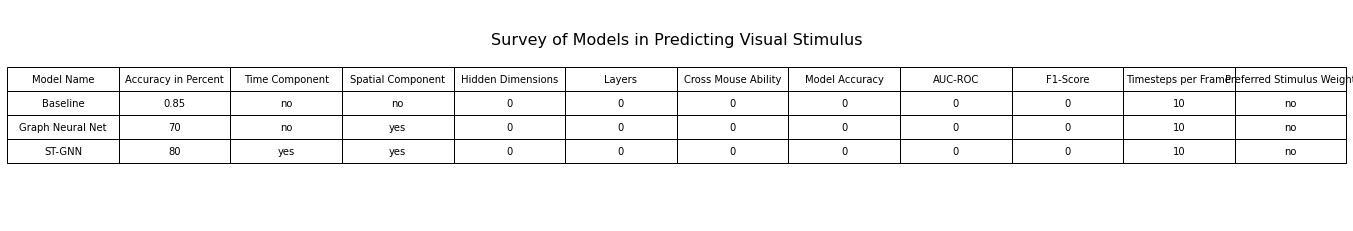

In [18]:
import matplotlib.pyplot as plt

# Sample DataFrame
data = {
    'Model Name': ['Baseline', 'Graph Neural Net', 'ST-GNN'],
    'Accuracy in Percent':['0.85','70','80'],
    'Time Component': ['no', 'no', 'yes'],
    'Spatial Component': ['no', 'yes', 'yes'],
    'Hidden Dimensions': [0, 0, 0],
    'Layers': [0, 0, 0],
    'Cross Mouse Ability': [0, 0, 0],
    'Model Accuracy': [0, 0, 0],
    'AUC-ROC': [0, 0, 0],
    'F1-Score': [0, 0, 0],
    'Timesteps per Frame': [10, 10, 10],
    'Preferred Stimulus Weight':['no','no','no']
}
grouped_df_for_latex = pd.DataFrame(data)

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 4), frameon=False) # set the size that you'd like (width, height)
ax.axis('tight')
ax.axis('off')

# Create table and set the fontsize and position
table = ax.table(cellText=grouped_df_for_latex.values,
                 colLabels=grouped_df_for_latex.columns,
                 cellLoc = 'center', 
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(2.0, 2.0)

# Add title
plt.title("Survey of Models in Predicting Visual Stimulus", fontsize=16, y=.8)

plt.show()


### 4.2) Build a graph for the network at each timestep. (Might need code to visualize later.)

Help resources: 
- https://pytorch-geometric-temporal.readthedocs.io/en/latest/
- https://github.com/topics/spatio-temporal-analysis?l=python
- https://analyticsindiamag.com/a-beginners-guide-to-spatio-temporal-graph-neural-networks/


In [ ]:
import os
import numpy as np
import networkx as nx
import pickle
from tqdm import tqdm
import time
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

In [ ]:
# Create the directory if it doesn't exist
if not os.path.exists("graphs_721123822"):
    os.makedirs("graphs_721123822")

# Calculate correlations
correlations = np.corrcoef(filtered_normalized_firing_rates.drop(columns=['frame']).T)

def create_graph(graph_index):
    # Create a graph for this timestep
    G = nx.Graph()
    firing_rates = filtered_normalized_firing_rates.iloc[graph_index, 1:]
    # Add nodes
    G.add_nodes_from(filtered_normalized_firing_rates.columns[1:])
    
    for neuron, rate in zip(filtered_normalized_firing_rates.columns[1:], firing_rates):
        G.add_node(neuron, rate=rate)

    # Add edges
    for i, neuron1 in enumerate(filtered_normalized_firing_rates.columns[1:]):
        for j, neuron2 in enumerate(filtered_normalized_firing_rates.columns[1:]):
            if i != j and correlations[i, j] > 0.25:  # Only add an edge if the correlation is above 0.5
                G.add_edge(neuron1, neuron2, weight=correlations[i, j])
    
    # Add y variable as graph attribute
    G.graph['frame'] = filtered_normalized_firing_rates.iloc[graph_index, 0]  # Assuming 'frame' is the first column

    return G, graph_index

def save_graph(G, graph_index):
    # Determine the folder based on the graph_index
    subfolder_name = f"graphs_721123822_{graph_index // 10000}"
    
    # Create the main directory if it doesn't exist
    main_folder = "graphs_721123822"
    if not os.path.exists(main_folder):
        os.makedirs(main_folder)
    
    # Create the subdirectory inside the main directory
    folder_name = os.path.join(main_folder, subfolder_name)
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Save the graph to a file in the "graphs" directory
    with open(os.path.join(folder_name, f"graph_{graph_index}.pkl"), 'wb') as f:  # Save in pickle format
        pickle.dump(G, f)

# Define the batch size
batch_size = 200

# Calculate the number of batches
num_batches = len(filtered_normalized_firing_rates) // batch_size + 1

# Create a ProcessPoolExecutor for graph creation and a ThreadPoolExecutor for I/O
with ProcessPoolExecutor(max_workers=2) as executor, ThreadPoolExecutor(max_workers=2) as io_executor:
    # Create a tqdm progress bar
    pbar = tqdm(total=num_batches)
    # Loop over each batch
    error_indices = []  # List to keep track of graphs that failed to be created or saved
    for batch in range(num_batches):
        # Create a list to hold the futures
        futures = []
        start_index = batch * batch_size
        end_index = (batch + 1) * batch_size
        # Use the executor to submit the create_graph function for each timestep in the batch
        for i in range(start_index, min(end_index, len(filtered_normalized_firing_rates))):
            try:
                futures.append(executor.submit(create_graph, i))
            except Exception as e:
                tqdm.write(f"Error creating graph {i}: {e}")  # Use tqdm.write instead of print
                error_indices.append(i)  # Append the index to the error list

        # Wait for all futures to complete for this batch
        for future in as_completed(futures):
            # Use the io_executor to submit the save_graph function
            try:
                G, i = future.result()
                io_executor.submit(save_graph, G, i)
            except Exception as e:
                tqdm.write(f"Error saving graph {i}: {e}")  # Use tqdm.write instead of print
                error_indices.append(i)  # Append the index to the error list
        # Update the progress bar
        pbar.update(1)
    # Close the progress bar
    pbar.close()

tqdm.write("Indices of graphs that failed to be created or saved:", error_indices)  # Use tqdm.write instead of print

#### Visualize

- 3D realistic neuron visualizations and wiggly graph(dude's a computational neuroscientist): https://www.youtube.com/watch?v=yaa13eehgzo&ab_channel=ArtemKirsanov

In [ ]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import os
import pickle
from IPython.display import Image, display

def generate_graphs(num_graphs, session_number):
    # Create the output folder based on the session number
    output_folder = f"graph_visualizations_{session_number}"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # List to store the file paths of the images
    image_file_paths = []

    for i in range(num_graphs):
        # Determine the subdirectory based on the graph index
        subdirectory = f"graphs_721123822_{i // 10000}"

        # Load the graph from the file
        with open(os.path.join("graphs_721123822", subdirectory, f"graph_{i}.pkl"), 'rb') as f:
            G = pickle.load(f)

        # Create a new figure
        plt.figure(figsize=(10, 10))

        # Get firing rates
        rates = {n: d['rate'] for n, d in G.nodes(data=True)}

        # Map firing rates to node sizes (you can adjust the scaling factor as needed)
        node_sizes = [50 * rate for rate in rates.values()]

        # Normalize firing rates to the range 0 to 1 for color mapping
        max_rate = max(rates.values())
        normalized_rates = [rate / max_rate for rate in rates.values()]

        # Map normalized firing rates to colors using a color map
        node_colors = [cm.hot(rate) for rate in normalized_rates]

        # Create a list of edges to remove
        edges_to_remove = [(u, v) for u, v in G.edges() if rates[u] <= 0 and rates[v] <= 0]

        # Remove the edges
        G.remove_edges_from(edges_to_remove)

        # Get edge weights
        edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]

        # Map edge weights to colors using a color map
        edge_colors = [cm.cool(weight) for weight in edge_weights]

        # Draw the graph as a circle
        plt.gca().set_facecolor('black')
        pos = nx.circular_layout(G)
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=1)

        # Save the figure to a file in the output folder
        image_file_path = os.path.join(output_folder, f"graph_{i}.png")
        plt.savefig(image_file_path, facecolor='black')
        image_file_paths.append(image_file_path)

        # Clear the figure so that the next graph is not drawn on top of this one
        plt.clf()

    # Sort the image file paths numerically based on the index value
    image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[1].split('.')[0]))

    # Create a GIF with a dynamic file name
    gif_file_path = f"graph_sequence_{num_graphs}.gif"

    # Create a GIF
    with imageio.get_writer(gif_file_path, mode='I', loop=0) as writer:
        for image_file_path in image_file_paths:
            image = imageio.imread(image_file_path)
            writer.append_data(image)

    # Display the GIF
    display(Image(filename=gif_file_path))
    
generate_graphs(num_graphs=100, session_number=721123822)

In [ ]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import os
import pickle
from IPython.display import Image, display

# List to store the file paths of the images
image_file_paths = []
num_graphs = 10
for i in range(num_graphs):
        # Determine the subdirectory based on the graph index
        subdirectory = f"graphs_721123822_{i // 10000}"
        # Load the graph from the file
        with open(os.path.join("graphs_721123822", subdirectory, f"graph_{i}.pkl"), 'rb') as f:
            G = pickle.load(f)

        # Create a new figure
        plt.figure(figsize=(10, 10))

        # Get firing rates
        rates = {n: d['rate'] for n, d in G.nodes(data=True)}

        # Map firing rates to node sizes (you can adjust the scaling factor as needed)
        node_sizes = [50 * rate for rate in rates.values()]

        # Normalize firing rates to the range 0 to 1 for color mapping
        max_rate = max(rates.values())
        normalized_rates = [rate / max_rate for rate in rates.values()]

        # Map normalized firing rates to colors using a color map
        node_colors = [cm.hot(rate) for rate in normalized_rates]

        # Create a list of edges to remove
        edges_to_remove = [(u, v) for u, v in G.edges() if rates[u] <= 0 and rates[v] <= 0]

        # Remove the edges
        G.remove_edges_from(edges_to_remove)

        # Get edge weights
        edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]

        # Map edge weights to colors using a color map
        edge_colors = [cm.cool(weight) for weight in edge_weights]

        # Draw the graph
        plt.gca().set_facecolor('black')
        pos = nx.kamada_kawai_layout(G)
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=1)

        # Save the figure to a file
        image_file_path = f"graph_{i}.png"
        plt.savefig(image_file_path, facecolor='black')
        image_file_paths.append(image_file_path)

        # Clear the figure so that the next graph is not drawn on top of this one
        plt.clf()

# Sort the image file paths numerically based on the index value
image_file_paths.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

# Create a GIF
with imageio.get_writer('graph_sequence.gif', mode='I', loop=0) as writer:
    for image_file_path in image_file_paths:
        image = imageio.imread(image_file_path)
        writer.append_data(image)

# Display the GIF
display(Image(filename='graph_sequence.gif'))


In [ ]:
with open(os.path.join("graphs_721123822/graphs_721123822_0/graph_10.pkl"), 'rb') as f:
    pickle.load("graph_10.pkl")

In [ ]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import os
import pickle
from IPython.display import Image, display

def generate_graphs(num_graphs, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # List to store the file paths of the images
    image_file_paths = []

    for i in range(num_graphs):
        # Determine the subdirectory based on the graph index
        subdirectory = f"graphs_721123822_{i // 10000}"

        # Load the graph from the file
        with open(os.path.join("graphs_721123822", subdirectory, f"graph_{i}.pkl"), 'rb') as f:
            G = pickle.load(f)

        # Create a new figure
        plt.figure(figsize=(10, 10))

        # Get firing rates
        rates = {n: d['rate'] for n, d in G.nodes(data=True)}

        # Map firing rates to node sizes (you can adjust the scaling factor as needed)
        node_sizes = [50 * rate for rate in rates.values()]

        # Normalize firing rates to the range 0 to 1 for color mapping
        max_rate = max(rates.values())
        normalized_rates = [rate / max_rate for rate in rates.values()]

        # Map normalized firing rates to colors using a color map
        node_colors = [cm.hot(rate) for rate in normalized_rates]

        # Create a list of edges to remove
        edges_to_remove = [(u, v) for u, v in G.edges() if rates[u] <= 0 and rates[v] <= 0]

        # Remove the edges
        G.remove_edges_from(edges_to_remove)

        # Get edge weights
        edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]

        # Map edge weights to colors using a color map
        edge_colors = [cm.cool(weight) for weight in edge_weights]

        # Draw the graph
        plt.gca().set_facecolor('black')
        pos = nx.kamada_kawai_layout(G)
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=1)

        # Save the figure to a file in the output folder
        image_file_path = os.path.join(output_folder, f"graph_{i}.png")
        plt.savefig(image_file_path, facecolor='black')
        image_file_paths.append(image_file_path)

        # Clear the figure so that the next graph is not drawn on top of this one
        plt.clf()

    # Sort the image file paths numerically based on the index value
    image_file_paths.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

    # Create a GIF
    gif_file_path = os.path.join(output_folder, "graph_sequence.gif")
    with imageio.get_writer(gif_file_path, mode='I', loop=0) as writer:
        for image_file_path in image_file_paths:
            image = imageio.imread(image_file_path)
            writer.append_data(image)

    # Display the GIF
    display(Image(filename=gif_file_path))

    
generate_graphs(num_graphs=10, output_folder="output_folder")

In [ ]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import os
import pickle
from IPython.display import Image, display

# List to store the file paths of the images
image_file_paths = []

for i in range(10):
    # Load the graph
    with open(os.path.join("graphs_721123822", f"graph_{i}.pkl"), 'rb') as f:
        G = pickle.load(f)

    # Create a new figure
    plt.figure(figsize=(10, 10))

    # Get firing rates
    rates = {n: d['rate'] for n, d in G.nodes(data=True)}

    # Map firing rates to node sizes (you can adjust the scaling factor as needed)
    node_sizes = [50 * rate for rate in rates.values()]

    # Normalize firing rates to the range 0 to 1 for color mapping
    max_rate = max(rates.values())
    normalized_rates = [rate / max_rate for rate in rates.values()]

    # Map normalized firing rates to colors using a color map
    node_colors = [cm.hot(rate) for rate in normalized_rates]

    # Create a list of edges to remove
    edges_to_remove = [(u, v) for u, v in G.edges() if rates[u] <= 0 and rates[v] <= 0]

    # Remove the edges
    G.remove_edges_from(edges_to_remove)

    # Get edge weights
    edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]

    # Map edge weights to colors using a color map
    edge_colors = [cm.cool(weight) for weight in edge_weights]

    # Draw the graph
    plt.gca().set_facecolor('black')
    pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=1)

    # Save the figure to a file
    image_file_path = f"graph_{i}.png"
    plt.savefig(image_file_path, facecolor='black')
    image_file_paths.append(image_file_path)

    # Clear the figure so that the next graph is not drawn on top of this one
    plt.clf()

# Sort the image file paths numerically based on the index value
image_file_paths.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

# Create a GIF
with imageio.get_writer('graph_sequence.gif', mode='I', loop=0) as writer:
    for image_file_path in image_file_paths:
        image = imageio.imread(image_file_path)
        writer.append_data(image)

# Display the GIF
display(Image(filename='graph_sequence.gif'))


In [ ]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import os
import pickle
from IPython.display import Image, display

# List to store the file paths of the images
image_file_paths = []

for i in range(10):
    # Load the graph
    with open(os.path.join("graphs_721123822", f"graph_{i}.pkl"), 'rb') as f:
        G = pickle.load(f)

    # Create a new figure
    plt.figure(figsize=(10, 10))

    # Get firing rates
    rates = {n: d['rate'] for n, d in G.nodes(data=True)}

    # Map firing rates to node sizes (you can adjust the scaling factor as needed)
    node_sizes = [50 * rate for rate in rates.values()]

    # Normalize firing rates to the range 0 to 1 for color mapping
    max_rate = max(rates.values())
    normalized_rates = [rate / max_rate for rate in rates.values()]

    # Map normalized firing rates to colors using a color map
    node_colors = [cm.hot(rate) for rate in normalized_rates]

    # Create a list of edges to remove
    edges_to_remove = [(u, v) for u, v in G.edges() if rates[u] <= 0 and rates[v] <= 0]

    # Remove the edges
    G.remove_edges_from(edges_to_remove)

    # Get edge weights
    edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]

    # Map edge weights to colors using a color map
    edge_colors = [cm.cool(weight) for weight in edge_weights]

    # Draw the graph
    plt.gca().set_facecolor('black')
    pos = nx.random_layout(G, seed = 69)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=1)

    # Save the figure to a file
    image_file_path = f"graph_{i}.png"
    plt.savefig(image_file_path, facecolor='black')
    image_file_paths.append(image_file_path)

    # Clear the figure so that the next graph is not drawn on top of this one
    plt.clf()

# Sort the image file paths numerically based on the index value
image_file_paths.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

# Create a GIF
with imageio.get_writer('graph_sequence.gif', mode='I', loop=0) as writer:
    for image_file_path in image_file_paths:
        image = imageio.imread(image_file_path)
        writer.append_data(image)

# Display the GIF
display(Image(filename='graph_sequence.gif'))


<a name="references"></a>
# References 
[Go to Outline](#outline)

##### Neuropixel References

- Data white paper: Allen Brain Observatory – Neuropixels Visual Coding, https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/80/75/8075a100-ca64-429a-b39a-569121b612b2/neuropixels_visual_coding_-_white_paper_v10.pdf
- neuropixel data overview: Large-scale neural recordings with single neuron resolution using Neuropixels probes in human cortex,https://www.nature.com/articles/s41593-021-00997-0
- more neuropixel data overview: Fully integrated silicon probes for high-density recording of neural activity, https://www.nature.com/articles/nature24636
- synaptic transmission: https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/synaptic-transmission
- Uses same type of data(mouse visual cortex neurons w/ HD-MEA): https://www.nature.com/articles/s41586-019-1346-5
     - Shows similar images may invoke similar responses to save on personal computation.
- Study on same Dataset, uses 'Gain' model. https://elifesciences.org/articles/77907#s4

##### LSTM References

- Paper model overview: http://www.bioinf.jku.at/publications/older/2604.pdf 
- Another Paper: https://proceedings.neurips.cc/paper_files/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf 
- Explanation - This guy worked at the stats dept at UNC I believe. https://www.youtube.com/watch?v=YCzL96nL7j0&ab_channel=StatQuestwithJoshStarmer 
- step by step: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

##### Spatio-Temporal GNN References: 

- How attentive are graph attention networks? https://arxiv.org/pdf/2105.14491.pdf
- Adaptive weights for adjacency matrix in STGNN: https://www.ijcai.org/proceedings/2019/0264.pdf
- Discertation"Applications of Spatio-Temporal Graph Neural Network Models for Brain Connectivity Analysis": https://epub.uni-regensburg.de/53477/1/Dissertation_SimonWein.pdf
- Video reference: https://www.youtube.com/watch?v=RRMU8kJH60Q&t=250s&ab_channel=JacobHeglund
    - Code from video: https://drive.google.com/file/d/1WpBOZlDiDTTeeXN1gr31TMCWeh4qWW7W/view
- Attention Based Spatial-Temporal Graph Convolutional Networks(ASTGCN) - ***Paper referenced in video above: https://guoshnbjtu.github.io/pdfs/AAAI2019-GuoS.2690.pdf
- STGNN for diagnosis of Depression (fMRI):https://onlinelibrary.wiley.com/doi/10.1002/hbm.25529
- TEMPORAL GRAPH NETWORKS FOR DEEP LEARNING ON DYNAMIC GRAPHS: https://arxiv.org/pdf/2006.10637.pdf
- Another Video Reference: https://www.youtube.com/watch?v=WEWq93tioC4&ab_channel=DeepFindr
- Older paper on Temporal Graph Networks: https://arxiv.org/pdf/2006.10637.pdf
- Pytorch and STGNNs: https://arxiv.org/pdf/2104.07788.pdf
- Survey of STGNNs: https://arxiv.org/abs/2301.10569

- STGNN predicting resting states in fMRI: https://www.sciencedirect.com/science/article/pii/S1361841522001189
- Spatio-Temporal Graph Convolution for Resting-State fMRI Analysis https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7700758/
- STGNN for flood forecasting: https://www.nature.com/articles/s41598-023-32548-x
- Other types of predictive Graph Networks - https://jonathan-hui.medium.com/graph-neural-networks-gnn-gae-stgnn-1ac0b5c99550
- "Graph neural networks: A review of methods and applications":https://www.sciencedirect.com/science/article/pii/S2666651021000012

##### Learnable Adjacency Matrix

- Overview of GAT: https://arxiv.org/abs/1710.10903
- Adaptive GCNN: https://arxiv.org/abs/1801.03226

##### Functional Connectomic References

- Functional brain networks reflect spatial and temporal autocorrelation(fMRI study): https://www.nature.com/articles/s41593-023-01299-3
- Using GNN to show changes in functional connectivity : https://www.frontiersin.org/articles/10.3389/fninf.2022.1032538/full
            - The above paper shows that showing the funcitonal connectivity in a GNN using graphsage is useful for predicting drug changes in functional connectivit.
            - They used umap in python to show groupings related to change in states.
- A graph neural network framework for causal inference in brain networks(fMRI study): https://www.nature.com/articles/s41598-021-87411-8
- Distinct brain-wide presynaptic networks underlie the functional identity of individual cortical neurons : https://www.biorxiv.org/content/10.1101/2023.05.25.542329v1
- Overview of other models used to find Functional Connectomics in the mouse visual cortex: https://www.biorxiv.org/content/10.1101/662189v2.full
- Older paper on overview on identifying Functional Connectivity in single neurons:https://direct.mit.edu/neco/article-abstract/21/2/450/8696/Identifying-Functional-Connectivity-in-Large-Scale?redirectedFrom=fulltext
- Learning-Induced Enduring Changes in Functional Connectivity among Prefrontal Cortical Neurons: https://www.jneurosci.org/content/27/4/909

##### Possible Future models
- Graph LSTMs
- Generating model for GNN: Discovering Symbolic Models from Deep Learning with Inductive Biases - https://www.youtube.com/watch?v=LMb5tvW-UoQ&ab_channel=YannicKilcher 
        -paper: https://arxiv.org/abs/2006.11287 
        -Code: https://github.com/MilesCranmer/symbolic_deep_learning
- Method to scale STGNNs to compute more timesteps: https://arxiv.org/abs/2209.06520
- Physics Informed Neural Net(PINN): https://arxiv.org/abs/2201.05624 
        - Similar to Discovering Symbolic Models from Deep Learning with Inductive Biases: https://www.youtube.com/watch?v=LMb5tvW-UoQ&t=1217s&ab_channel=YannicKilcher 
        - Converting NNs to symbolic models "https://www.youtube.com/watch?v=wmQIcTOzH0k&ab_channel=MilesCranmer"